In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2010250, 828)
(2010250, 8)
validation
(235568, 828)
(235568, 8)
test
(285739, 828)
(285739, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/202 [..............................] - ETA: 4:30 - loss: 2.1641 - STD: 0.0554 - MAE: 0.2191

  4/202 [..............................] - ETA: 3s - loss: 2.0894 - STD: 0.0472 - MAE: 0.2168  

  7/202 [>.............................] - ETA: 3s - loss: 2.0852 - STD: 0.0449 - MAE: 0.2167

 10/202 [>.............................] - ETA: 3s - loss: 2.0762 - STD: 0.0433 - MAE: 0.2165

 13/202 [>.............................] - ETA: 3s - loss: 2.0706 - STD: 0.0405 - MAE: 0.2166

 16/202 [=>............................] - ETA: 3s - loss: 2.0660 - STD: 0.0382 - MAE: 0.2166

 19/202 [=>............................] - ETA: 3s - loss: 2.0612 - STD: 0.0378 - MAE: 0.2165

 22/202 [==>...........................] - ETA: 3s - loss: 2.0551 - STD: 0.0376 - MAE: 0.2163

 25/202 [==>...........................] - ETA: 3s - loss: 2.0479 - STD: 0.0378 - MAE: 0.2161

 28/202 [===>..........................] - ETA: 3s - loss: 2.0382 - STD: 0.0388 - MAE: 0.2156

 31/202 [===>..........................] - ETA: 3s - loss: 2.0279 - STD: 0.0407 - MAE: 0.2151

 34/202 [====>.........................] - ETA: 3s - loss: 2.0173 - STD: 0.0428 - MAE: 0.2145

 37/202 [====>.........................] - ETA: 2s - loss: 2.0059 - STD: 0.0449 - MAE: 0.2139

 40/202 [====>.........................] - ETA: 2s - loss: 1.9945 - STD: 0.0471 - MAE: 0.2133

 43/202 [=====>........................] - ETA: 2s - loss: 1.9828 - STD: 0.0491 - MAE: 0.2127

 46/202 [=====>........................] - ETA: 2s - loss: 1.9705 - STD: 0.0510 - MAE: 0.2121

 49/202 [======>.......................] - ETA: 4s - loss: 1.9618 - STD: 0.0532 - MAE: 0.2114

 52/202 [======>.......................] - ETA: 4s - loss: 1.9480 - STD: 0.0553 - MAE: 0.2107

 55/202 [=======>......................] - ETA: 4s - loss: 1.9335 - STD: 0.0574 - MAE: 0.2099

 58/202 [=======>......................] - ETA: 4s - loss: 1.9178 - STD: 0.0596 - MAE: 0.2091

 61/202 [========>.....................] - ETA: 3s - loss: 1.9012 - STD: 0.0617 - MAE: 0.2082

 64/202 [========>.....................] - ETA: 3s - loss: 1.8841 - STD: 0.0641 - MAE: 0.2072

 67/202 [========>.....................] - ETA: 3s - loss: 1.8670 - STD: 0.0665 - MAE: 0.2062

 70/202 [=========>....................] - ETA: 3s - loss: 1.8498 - STD: 0.0690 - MAE: 0.2052

 73/202 [=========>....................] - ETA: 3s - loss: 1.8333 - STD: 0.0716 - MAE: 0.2041

 76/202 [==========>...................] - ETA: 3s - loss: 1.8171 - STD: 0.0740 - MAE: 0.2031

 79/202 [==========>...................] - ETA: 3s - loss: 1.8014 - STD: 0.0764 - MAE: 0.2021

 82/202 [===========>..................] - ETA: 3s - loss: 1.7870 - STD: 0.0788 - MAE: 0.2011

 85/202 [===========>..................] - ETA: 2s - loss: 1.7724 - STD: 0.0810 - MAE: 0.2001

 88/202 [============>.................] - ETA: 2s - loss: 1.7589 - STD: 0.0832 - MAE: 0.1991

 91/202 [============>.................] - ETA: 2s - loss: 1.7455 - STD: 0.0853 - MAE: 0.1982

 94/202 [============>.................] - ETA: 2s - loss: 1.7327 - STD: 0.0874 - MAE: 0.1973

 97/202 [=============>................] - ETA: 2s - loss: 1.7205 - STD: 0.0894 - MAE: 0.1964

100/202 [=============>................] - ETA: 2s - loss: 1.7086 - STD: 0.0914 - MAE: 0.1955

103/202 [==============>...............] - ETA: 2s - loss: 1.6970 - STD: 0.0933 - MAE: 0.1946

106/202 [==============>...............] - ETA: 2s - loss: 1.6861 - STD: 0.0951 - MAE: 0.1938

109/202 [===============>..............] - ETA: 2s - loss: 1.6752 - STD: 0.0969 - MAE: 0.1929

112/202 [===============>..............] - ETA: 2s - loss: 1.6647 - STD: 0.0986 - MAE: 0.1921

115/202 [================>.............] - ETA: 2s - loss: 1.6548 - STD: 0.1002 - MAE: 0.1913

118/202 [================>.............] - ETA: 1s - loss: 1.6449 - STD: 0.1019 - MAE: 0.1905

121/202 [================>.............] - ETA: 1s - loss: 1.6353 - STD: 0.1035 - MAE: 0.1898

124/202 [=================>............] - ETA: 1s - loss: 1.6265 - STD: 0.1050 - MAE: 0.1891

127/202 [=================>............] - ETA: 1s - loss: 1.6174 - STD: 0.1064 - MAE: 0.1883

130/202 [==================>...........] - ETA: 1s - loss: 1.6088 - STD: 0.1079 - MAE: 0.1876

133/202 [==================>...........] - ETA: 1s - loss: 1.6006 - STD: 0.1093 - MAE: 0.1870

136/202 [===================>..........] - ETA: 1s - loss: 1.5924 - STD: 0.1107 - MAE: 0.1863

139/202 [===================>..........] - ETA: 1s - loss: 1.5845 - STD: 0.1120 - MAE: 0.1856

142/202 [====================>.........] - ETA: 1s - loss: 1.5769 - STD: 0.1133 - MAE: 0.1850

145/202 [====================>.........] - ETA: 1s - loss: 1.5697 - STD: 0.1146 - MAE: 0.1844

148/202 [====================>.........] - ETA: 1s - loss: 1.5625 - STD: 0.1158 - MAE: 0.1837

151/202 [=====================>........] - ETA: 1s - loss: 1.5555 - STD: 0.1170 - MAE: 0.1831

154/202 [=====================>........] - ETA: 1s - loss: 1.5488 - STD: 0.1182 - MAE: 0.1826

158/202 [======================>.......] - ETA: 0s - loss: 1.5402 - STD: 0.1197 - MAE: 0.1818

162/202 [=======================>......] - ETA: 0s - loss: 1.5320 - STD: 0.1212 - MAE: 0.1811

165/202 [=======================>......] - ETA: 0s - loss: 1.5260 - STD: 0.1222 - MAE: 0.1806

168/202 [=======================>......] - ETA: 0s - loss: 1.5201 - STD: 0.1232 - MAE: 0.1800

171/202 [========================>.....] - ETA: 0s - loss: 1.5143 - STD: 0.1243 - MAE: 0.1795

174/202 [========================>.....] - ETA: 0s - loss: 1.5086 - STD: 0.1252 - MAE: 0.1790

177/202 [=========================>....] - ETA: 0s - loss: 1.5032 - STD: 0.1262 - MAE: 0.1786

180/202 [=========================>....] - ETA: 0s - loss: 1.4977 - STD: 0.1271 - MAE: 0.1781

183/202 [==========================>...] - ETA: 0s - loss: 1.4924 - STD: 0.1280 - MAE: 0.1776

186/202 [==========================>...] - ETA: 0s - loss: 1.4873 - STD: 0.1289 - MAE: 0.1772

189/202 [===========================>..] - ETA: 0s - loss: 1.4824 - STD: 0.1298 - MAE: 0.1767

192/202 [===========================>..] - ETA: 0s - loss: 1.4776 - STD: 0.1306 - MAE: 0.1763

195/202 [===========================>..] - ETA: 0s - loss: 1.4730 - STD: 0.1314 - MAE: 0.1759

198/202 [============================>.] - ETA: 0s - loss: 1.4683 - STD: 0.1322 - MAE: 0.1755

201/202 [============================>.] - ETA: 0s - loss: 1.4637 - STD: 0.1330 - MAE: 0.1750

202/202 [==============================] - 7s 26ms/step - loss: 1.4621 - STD: 0.1333 - MAE: 0.1749 - val_loss: 1.2264 - val_STD: 0.1885 - val_MAE: 0.1494


Epoch 2/10000


  1/202 [..............................] - ETA: 8s - loss: 1.1659 - STD: 0.1877 - MAE: 0.1469

  4/202 [..............................] - ETA: 4s - loss: 1.1618 - STD: 0.1864 - MAE: 0.1475

  7/202 [>.............................] - ETA: 3s - loss: 1.1613 - STD: 0.1865 - MAE: 0.1475

 10/202 [>.............................] - ETA: 3s - loss: 1.1612 - STD: 0.1863 - MAE: 0.1475

 13/202 [>.............................] - ETA: 3s - loss: 1.1591 - STD: 0.1863 - MAE: 0.1474

 17/202 [=>............................] - ETA: 3s - loss: 1.1557 - STD: 0.1865 - MAE: 0.1472

 20/202 [=>............................] - ETA: 3s - loss: 1.1541 - STD: 0.1867 - MAE: 0.1470

 23/202 [==>...........................] - ETA: 3s - loss: 1.1521 - STD: 0.1870 - MAE: 0.1468

 26/202 [==>...........................] - ETA: 3s - loss: 1.1520 - STD: 0.1871 - MAE: 0.1468

 29/202 [===>..........................] - ETA: 3s - loss: 1.1502 - STD: 0.1873 - MAE: 0.1466

 32/202 [===>..........................] - ETA: 3s - loss: 1.1492 - STD: 0.1876 - MAE: 0.1465

 35/202 [====>.........................] - ETA: 2s - loss: 1.1483 - STD: 0.1877 - MAE: 0.1463

 38/202 [====>.........................] - ETA: 2s - loss: 1.1469 - STD: 0.1878 - MAE: 0.1462

 41/202 [=====>........................] - ETA: 2s - loss: 1.1456 - STD: 0.1881 - MAE: 0.1461

 44/202 [=====>........................] - ETA: 2s - loss: 1.1445 - STD: 0.1883 - MAE: 0.1459

 47/202 [=====>........................] - ETA: 2s - loss: 1.1436 - STD: 0.1885 - MAE: 0.1458

 51/202 [======>.......................] - ETA: 2s - loss: 1.1424 - STD: 0.1886 - MAE: 0.1457

 54/202 [=======>......................] - ETA: 2s - loss: 1.1413 - STD: 0.1888 - MAE: 0.1456

 57/202 [=======>......................] - ETA: 2s - loss: 1.1403 - STD: 0.1889 - MAE: 0.1455

 60/202 [=======>......................] - ETA: 2s - loss: 1.1395 - STD: 0.1891 - MAE: 0.1454

 63/202 [========>.....................] - ETA: 2s - loss: 1.1389 - STD: 0.1893 - MAE: 0.1453

 66/202 [========>.....................] - ETA: 2s - loss: 1.1394 - STD: 0.1894 - MAE: 0.1452

 69/202 [=========>....................] - ETA: 2s - loss: 1.1388 - STD: 0.1895 - MAE: 0.1452

 72/202 [=========>....................] - ETA: 2s - loss: 1.1376 - STD: 0.1896 - MAE: 0.1451

 75/202 [==========>...................] - ETA: 2s - loss: 1.1372 - STD: 0.1897 - MAE: 0.1450

 78/202 [==========>...................] - ETA: 2s - loss: 1.1361 - STD: 0.1899 - MAE: 0.1449

 81/202 [===========>..................] - ETA: 2s - loss: 1.1352 - STD: 0.1900 - MAE: 0.1448

 85/202 [===========>..................] - ETA: 2s - loss: 1.1341 - STD: 0.1902 - MAE: 0.1446

 88/202 [============>.................] - ETA: 2s - loss: 1.1335 - STD: 0.1904 - MAE: 0.1446

 92/202 [============>.................] - ETA: 1s - loss: 1.1323 - STD: 0.1905 - MAE: 0.1445

 95/202 [=============>................] - ETA: 1s - loss: 1.1315 - STD: 0.1906 - MAE: 0.1444

 98/202 [=============>................] - ETA: 1s - loss: 1.1305 - STD: 0.1907 - MAE: 0.1443

101/202 [==============>...............] - ETA: 1s - loss: 1.1295 - STD: 0.1909 - MAE: 0.1442

105/202 [==============>...............] - ETA: 1s - loss: 1.1285 - STD: 0.1910 - MAE: 0.1441

109/202 [===============>..............] - ETA: 1s - loss: 1.1276 - STD: 0.1912 - MAE: 0.1439

112/202 [===============>..............] - ETA: 1s - loss: 1.1274 - STD: 0.1913 - MAE: 0.1439

115/202 [================>.............] - ETA: 1s - loss: 1.1268 - STD: 0.1914 - MAE: 0.1438

118/202 [================>.............] - ETA: 1s - loss: 1.1259 - STD: 0.1915 - MAE: 0.1437

121/202 [================>.............] - ETA: 1s - loss: 1.1256 - STD: 0.1916 - MAE: 0.1437

124/202 [=================>............] - ETA: 1s - loss: 1.1247 - STD: 0.1917 - MAE: 0.1436

127/202 [=================>............] - ETA: 1s - loss: 1.1241 - STD: 0.1918 - MAE: 0.1435

130/202 [==================>...........] - ETA: 1s - loss: 1.1234 - STD: 0.1919 - MAE: 0.1434

133/202 [==================>...........] - ETA: 1s - loss: 1.1225 - STD: 0.1920 - MAE: 0.1433

136/202 [===================>..........] - ETA: 1s - loss: 1.1218 - STD: 0.1921 - MAE: 0.1433

139/202 [===================>..........] - ETA: 1s - loss: 1.1212 - STD: 0.1922 - MAE: 0.1432

142/202 [====================>.........] - ETA: 1s - loss: 1.1204 - STD: 0.1923 - MAE: 0.1431

145/202 [====================>.........] - ETA: 1s - loss: 1.1196 - STD: 0.1924 - MAE: 0.1430

148/202 [====================>.........] - ETA: 0s - loss: 1.1188 - STD: 0.1926 - MAE: 0.1429

151/202 [=====================>........] - ETA: 0s - loss: 1.1180 - STD: 0.1927 - MAE: 0.1429

154/202 [=====================>........] - ETA: 0s - loss: 1.1171 - STD: 0.1928 - MAE: 0.1428

157/202 [======================>.......] - ETA: 0s - loss: 1.1165 - STD: 0.1929 - MAE: 0.1427

160/202 [======================>.......] - ETA: 0s - loss: 1.1158 - STD: 0.1930 - MAE: 0.1426

163/202 [=======================>......] - ETA: 0s - loss: 1.1153 - STD: 0.1931 - MAE: 0.1426

167/202 [=======================>......] - ETA: 0s - loss: 1.1145 - STD: 0.1932 - MAE: 0.1425

171/202 [========================>.....] - ETA: 0s - loss: 1.1140 - STD: 0.1933 - MAE: 0.1424

175/202 [========================>.....] - ETA: 0s - loss: 1.1131 - STD: 0.1935 - MAE: 0.1423

178/202 [=========================>....] - ETA: 0s - loss: 1.1124 - STD: 0.1936 - MAE: 0.1422

181/202 [=========================>....] - ETA: 0s - loss: 1.1120 - STD: 0.1937 - MAE: 0.1421

184/202 [==========================>...] - ETA: 0s - loss: 1.1112 - STD: 0.1938 - MAE: 0.1421

187/202 [==========================>...] - ETA: 0s - loss: 1.1105 - STD: 0.1939 - MAE: 0.1420

190/202 [===========================>..] - ETA: 0s - loss: 1.1098 - STD: 0.1939 - MAE: 0.1419

193/202 [===========================>..] - ETA: 0s - loss: 1.1092 - STD: 0.1940 - MAE: 0.1418

196/202 [============================>.] - ETA: 0s - loss: 1.1085 - STD: 0.1941 - MAE: 0.1418

200/202 [============================>.] - ETA: 0s - loss: 1.1076 - STD: 0.1943 - MAE: 0.1417

202/202 [==============================] - 4s 20ms/step - loss: 1.1072 - STD: 0.1943 - MAE: 0.1416 - val_loss: 1.1681 - val_STD: 0.2017 - val_MAE: 0.1416


Epoch 3/10000


  1/202 [..............................] - ETA: 10s - loss: 1.0586 - STD: 0.1994 - MAE: 0.1369

  4/202 [..............................] - ETA: 3s - loss: 1.0614 - STD: 0.1998 - MAE: 0.1370 

  7/202 [>.............................] - ETA: 3s - loss: 1.0563 - STD: 0.2004 - MAE: 0.1365

 10/202 [>.............................] - ETA: 3s - loss: 1.0587 - STD: 0.2006 - MAE: 0.1366

 13/202 [>.............................] - ETA: 3s - loss: 1.0635 - STD: 0.2007 - MAE: 0.1368

 17/202 [=>............................] - ETA: 3s - loss: 1.0792 - STD: 0.2007 - MAE: 0.1377

 20/202 [=>............................] - ETA: 3s - loss: 1.0800 - STD: 0.2008 - MAE: 0.1377

 23/202 [==>...........................] - ETA: 3s - loss: 1.0781 - STD: 0.2006 - MAE: 0.1376

 26/202 [==>...........................] - ETA: 3s - loss: 1.0771 - STD: 0.2005 - MAE: 0.1376

 29/202 [===>..........................] - ETA: 3s - loss: 1.0750 - STD: 0.2005 - MAE: 0.1375

 32/202 [===>..........................] - ETA: 3s - loss: 1.0724 - STD: 0.2005 - MAE: 0.1374

 36/202 [====>.........................] - ETA: 2s - loss: 1.0704 - STD: 0.2007 - MAE: 0.1372

 40/202 [====>.........................] - ETA: 2s - loss: 1.0687 - STD: 0.2007 - MAE: 0.1371

 43/202 [=====>........................] - ETA: 2s - loss: 1.0679 - STD: 0.2008 - MAE: 0.1370

 46/202 [=====>........................] - ETA: 2s - loss: 1.0668 - STD: 0.2008 - MAE: 0.1370

 49/202 [======>.......................] - ETA: 2s - loss: 1.0660 - STD: 0.2008 - MAE: 0.1369

 52/202 [======>.......................] - ETA: 2s - loss: 1.0648 - STD: 0.2009 - MAE: 0.1368

 55/202 [=======>......................] - ETA: 2s - loss: 1.0643 - STD: 0.2009 - MAE: 0.1368

 58/202 [=======>......................] - ETA: 2s - loss: 1.0634 - STD: 0.2010 - MAE: 0.1367

 61/202 [========>.....................] - ETA: 2s - loss: 1.0622 - STD: 0.2011 - MAE: 0.1366

 64/202 [========>.....................] - ETA: 2s - loss: 1.0610 - STD: 0.2012 - MAE: 0.1365

 67/202 [========>.....................] - ETA: 2s - loss: 1.0599 - STD: 0.2013 - MAE: 0.1364

 70/202 [=========>....................] - ETA: 2s - loss: 1.0591 - STD: 0.2014 - MAE: 0.1363

 73/202 [=========>....................] - ETA: 2s - loss: 1.0576 - STD: 0.2015 - MAE: 0.1362

 77/202 [==========>...................] - ETA: 2s - loss: 1.0565 - STD: 0.2016 - MAE: 0.1361

 80/202 [==========>...................] - ETA: 2s - loss: 1.0559 - STD: 0.2016 - MAE: 0.1360

 83/202 [===========>..................] - ETA: 2s - loss: 1.0552 - STD: 0.2017 - MAE: 0.1360

 86/202 [===========>..................] - ETA: 2s - loss: 1.0547 - STD: 0.2018 - MAE: 0.1359

 89/202 [============>.................] - ETA: 1s - loss: 1.0538 - STD: 0.2018 - MAE: 0.1358

 92/202 [============>.................] - ETA: 1s - loss: 1.0533 - STD: 0.2019 - MAE: 0.1358

 95/202 [=============>................] - ETA: 1s - loss: 1.0524 - STD: 0.2020 - MAE: 0.1357

 98/202 [=============>................] - ETA: 1s - loss: 1.0521 - STD: 0.2021 - MAE: 0.1356

101/202 [==============>...............] - ETA: 1s - loss: 1.0518 - STD: 0.2022 - MAE: 0.1356

104/202 [==============>...............] - ETA: 1s - loss: 1.0517 - STD: 0.2022 - MAE: 0.1356

107/202 [==============>...............] - ETA: 1s - loss: 1.0509 - STD: 0.2022 - MAE: 0.1355

110/202 [===============>..............] - ETA: 1s - loss: 1.0505 - STD: 0.2023 - MAE: 0.1354

113/202 [===============>..............] - ETA: 1s - loss: 1.0501 - STD: 0.2024 - MAE: 0.1354

117/202 [================>.............] - ETA: 1s - loss: 1.0495 - STD: 0.2025 - MAE: 0.1353

120/202 [================>.............] - ETA: 1s - loss: 1.0490 - STD: 0.2025 - MAE: 0.1353

123/202 [=================>............] - ETA: 1s - loss: 1.0485 - STD: 0.2026 - MAE: 0.1352

126/202 [=================>............] - ETA: 1s - loss: 1.0477 - STD: 0.2027 - MAE: 0.1351

129/202 [==================>...........] - ETA: 1s - loss: 1.0474 - STD: 0.2028 - MAE: 0.1351

132/202 [==================>...........] - ETA: 1s - loss: 1.0466 - STD: 0.2028 - MAE: 0.1350

136/202 [===================>..........] - ETA: 1s - loss: 1.0457 - STD: 0.2029 - MAE: 0.1349

139/202 [===================>..........] - ETA: 1s - loss: 1.0452 - STD: 0.2030 - MAE: 0.1349

142/202 [====================>.........] - ETA: 1s - loss: 1.0447 - STD: 0.2030 - MAE: 0.1349

146/202 [====================>.........] - ETA: 0s - loss: 1.0441 - STD: 0.2031 - MAE: 0.1348

149/202 [=====================>........] - ETA: 0s - loss: 1.0439 - STD: 0.2031 - MAE: 0.1348

153/202 [=====================>........] - ETA: 0s - loss: 1.0437 - STD: 0.2032 - MAE: 0.1347

156/202 [======================>.......] - ETA: 0s - loss: 1.0438 - STD: 0.2033 - MAE: 0.1347

159/202 [======================>.......] - ETA: 0s - loss: 1.0435 - STD: 0.2033 - MAE: 0.1347

162/202 [=======================>......] - ETA: 0s - loss: 1.0433 - STD: 0.2033 - MAE: 0.1347

165/202 [=======================>......] - ETA: 0s - loss: 1.0428 - STD: 0.2034 - MAE: 0.1346

168/202 [=======================>......] - ETA: 0s - loss: 1.0423 - STD: 0.2034 - MAE: 0.1346

171/202 [========================>.....] - ETA: 0s - loss: 1.0420 - STD: 0.2035 - MAE: 0.1345

174/202 [========================>.....] - ETA: 0s - loss: 1.0417 - STD: 0.2035 - MAE: 0.1345

177/202 [=========================>....] - ETA: 0s - loss: 1.0412 - STD: 0.2036 - MAE: 0.1345

180/202 [=========================>....] - ETA: 0s - loss: 1.0411 - STD: 0.2036 - MAE: 0.1344

183/202 [==========================>...] - ETA: 0s - loss: 1.0407 - STD: 0.2036 - MAE: 0.1344

186/202 [==========================>...] - ETA: 0s - loss: 1.0401 - STD: 0.2037 - MAE: 0.1343

189/202 [===========================>..] - ETA: 0s - loss: 1.0396 - STD: 0.2037 - MAE: 0.1343

192/202 [===========================>..] - ETA: 0s - loss: 1.0392 - STD: 0.2038 - MAE: 0.1343

195/202 [===========================>..] - ETA: 0s - loss: 1.0387 - STD: 0.2038 - MAE: 0.1342

198/202 [============================>.] - ETA: 0s - loss: 1.0381 - STD: 0.2039 - MAE: 0.1341

202/202 [==============================] - 4s 20ms/step - loss: 1.0377 - STD: 0.2040 - MAE: 0.1341 - val_loss: 1.1533 - val_STD: 0.2105 - val_MAE: 0.1370


Epoch 4/10000


  1/202 [..............................] - ETA: 10s - loss: 0.9851 - STD: 0.2081 - MAE: 0.1294

  4/202 [..............................] - ETA: 3s - loss: 1.0081 - STD: 0.2077 - MAE: 0.1310 

  7/202 [>.............................] - ETA: 3s - loss: 1.0068 - STD: 0.2065 - MAE: 0.1315

 10/202 [>.............................] - ETA: 3s - loss: 1.0073 - STD: 0.2066 - MAE: 0.1315

 13/202 [>.............................] - ETA: 3s - loss: 1.0052 - STD: 0.2064 - MAE: 0.1314

 17/202 [=>............................] - ETA: 3s - loss: 1.0250 - STD: 0.2075 - MAE: 0.1316

 20/202 [=>............................] - ETA: 3s - loss: 1.0289 - STD: 0.2079 - MAE: 0.1317

 23/202 [==>...........................] - ETA: 3s - loss: 1.0297 - STD: 0.2078 - MAE: 0.1318

 26/202 [==>...........................] - ETA: 3s - loss: 1.0291 - STD: 0.2074 - MAE: 0.1320

 29/202 [===>..........................] - ETA: 3s - loss: 1.0278 - STD: 0.2074 - MAE: 0.1319

 32/202 [===>..........................] - ETA: 3s - loss: 1.0257 - STD: 0.2074 - MAE: 0.1318

 35/202 [====>.........................] - ETA: 2s - loss: 1.0243 - STD: 0.2075 - MAE: 0.1318

 38/202 [====>.........................] - ETA: 2s - loss: 1.0229 - STD: 0.2074 - MAE: 0.1317

 41/202 [=====>........................] - ETA: 2s - loss: 1.0212 - STD: 0.2073 - MAE: 0.1317

 44/202 [=====>........................] - ETA: 2s - loss: 1.0196 - STD: 0.2073 - MAE: 0.1316

 47/202 [=====>........................] - ETA: 2s - loss: 1.0186 - STD: 0.2073 - MAE: 0.1316

 50/202 [======>.......................] - ETA: 2s - loss: 1.0172 - STD: 0.2073 - MAE: 0.1315

 53/202 [======>.......................] - ETA: 2s - loss: 1.0154 - STD: 0.2074 - MAE: 0.1313

 56/202 [=======>......................] - ETA: 2s - loss: 1.0140 - STD: 0.2075 - MAE: 0.1313

 59/202 [=======>......................] - ETA: 2s - loss: 1.0128 - STD: 0.2075 - MAE: 0.1312

 62/202 [========>.....................] - ETA: 2s - loss: 1.0117 - STD: 0.2076 - MAE: 0.1311

 65/202 [========>.....................] - ETA: 2s - loss: 1.0109 - STD: 0.2077 - MAE: 0.1310

 68/202 [=========>....................] - ETA: 2s - loss: 1.0097 - STD: 0.2078 - MAE: 0.1309

 71/202 [=========>....................] - ETA: 2s - loss: 1.0087 - STD: 0.2078 - MAE: 0.1308

 74/202 [=========>....................] - ETA: 2s - loss: 1.0085 - STD: 0.2080 - MAE: 0.1308

 77/202 [==========>...................] - ETA: 2s - loss: 1.0081 - STD: 0.2080 - MAE: 0.1307

 81/202 [===========>..................] - ETA: 2s - loss: 1.0075 - STD: 0.2081 - MAE: 0.1307

 84/202 [===========>..................] - ETA: 2s - loss: 1.0067 - STD: 0.2081 - MAE: 0.1306

 87/202 [===========>..................] - ETA: 2s - loss: 1.0061 - STD: 0.2081 - MAE: 0.1306

 90/202 [============>.................] - ETA: 1s - loss: 1.0056 - STD: 0.2082 - MAE: 0.1305

 93/202 [============>.................] - ETA: 1s - loss: 1.0050 - STD: 0.2083 - MAE: 0.1304

 96/202 [=============>................] - ETA: 1s - loss: 1.0047 - STD: 0.2083 - MAE: 0.1304

 99/202 [=============>................] - ETA: 1s - loss: 1.0045 - STD: 0.2084 - MAE: 0.1304

102/202 [==============>...............] - ETA: 1s - loss: 1.0040 - STD: 0.2084 - MAE: 0.1303

106/202 [==============>...............] - ETA: 1s - loss: 1.0037 - STD: 0.2084 - MAE: 0.1303

110/202 [===============>..............] - ETA: 1s - loss: 1.0035 - STD: 0.2085 - MAE: 0.1303

113/202 [===============>..............] - ETA: 1s - loss: 1.0031 - STD: 0.2086 - MAE: 0.1302

116/202 [================>.............] - ETA: 1s - loss: 1.0025 - STD: 0.2086 - MAE: 0.1302

119/202 [================>.............] - ETA: 1s - loss: 1.0018 - STD: 0.2087 - MAE: 0.1301

122/202 [=================>............] - ETA: 1s - loss: 1.0011 - STD: 0.2088 - MAE: 0.1300

125/202 [=================>............] - ETA: 1s - loss: 1.0004 - STD: 0.2088 - MAE: 0.1300

128/202 [==================>...........] - ETA: 1s - loss: 0.9999 - STD: 0.2088 - MAE: 0.1299

131/202 [==================>...........] - ETA: 1s - loss: 0.9993 - STD: 0.2089 - MAE: 0.1299

134/202 [==================>...........] - ETA: 1s - loss: 0.9983 - STD: 0.2089 - MAE: 0.1298

137/202 [===================>..........] - ETA: 1s - loss: 0.9977 - STD: 0.2090 - MAE: 0.1297

140/202 [===================>..........] - ETA: 1s - loss: 0.9973 - STD: 0.2091 - MAE: 0.1297

143/202 [====================>.........] - ETA: 1s - loss: 0.9968 - STD: 0.2091 - MAE: 0.1296

146/202 [====================>.........] - ETA: 1s - loss: 0.9964 - STD: 0.2092 - MAE: 0.1296

149/202 [=====================>........] - ETA: 0s - loss: 0.9964 - STD: 0.2092 - MAE: 0.1296

152/202 [=====================>........] - ETA: 0s - loss: 0.9961 - STD: 0.2093 - MAE: 0.1295

155/202 [======================>.......] - ETA: 0s - loss: 0.9959 - STD: 0.2093 - MAE: 0.1295

158/202 [======================>.......] - ETA: 0s - loss: 0.9954 - STD: 0.2094 - MAE: 0.1295

161/202 [======================>.......] - ETA: 0s - loss: 0.9950 - STD: 0.2094 - MAE: 0.1294

164/202 [=======================>......] - ETA: 0s - loss: 0.9944 - STD: 0.2094 - MAE: 0.1294

167/202 [=======================>......] - ETA: 0s - loss: 0.9941 - STD: 0.2095 - MAE: 0.1293

170/202 [========================>.....] - ETA: 0s - loss: 0.9936 - STD: 0.2095 - MAE: 0.1293

173/202 [========================>.....] - ETA: 0s - loss: 0.9932 - STD: 0.2096 - MAE: 0.1292

176/202 [=========================>....] - ETA: 0s - loss: 0.9929 - STD: 0.2096 - MAE: 0.1292

179/202 [=========================>....] - ETA: 0s - loss: 0.9927 - STD: 0.2097 - MAE: 0.1292

182/202 [==========================>...] - ETA: 0s - loss: 0.9923 - STD: 0.2098 - MAE: 0.1291

185/202 [==========================>...] - ETA: 0s - loss: 0.9917 - STD: 0.2098 - MAE: 0.1291

188/202 [==========================>...] - ETA: 0s - loss: 0.9913 - STD: 0.2098 - MAE: 0.1290

191/202 [===========================>..] - ETA: 0s - loss: 0.9910 - STD: 0.2099 - MAE: 0.1290

194/202 [===========================>..] - ETA: 0s - loss: 0.9904 - STD: 0.2099 - MAE: 0.1289

197/202 [============================>.] - ETA: 0s - loss: 0.9901 - STD: 0.2100 - MAE: 0.1289

200/202 [============================>.] - ETA: 0s - loss: 0.9896 - STD: 0.2100 - MAE: 0.1289

202/202 [==============================] - 4s 20ms/step - loss: 0.9893 - STD: 0.2100 - MAE: 0.1288 - val_loss: 1.1276 - val_STD: 0.2159 - val_MAE: 0.1337


Epoch 5/10000


  1/202 [..............................] - ETA: 9s - loss: 0.9644 - STD: 0.2129 - MAE: 0.1260

  4/202 [..............................] - ETA: 3s - loss: 0.9656 - STD: 0.2131 - MAE: 0.1262

  7/202 [>.............................] - ETA: 3s - loss: 0.9657 - STD: 0.2130 - MAE: 0.1262

 10/202 [>.............................] - ETA: 3s - loss: 0.9641 - STD: 0.2130 - MAE: 0.1261

 14/202 [=>............................] - ETA: 3s - loss: 0.9900 - STD: 0.2130 - MAE: 0.1274

 17/202 [=>............................] - ETA: 3s - loss: 1.0069 - STD: 0.2134 - MAE: 0.1282

 20/202 [=>............................] - ETA: 3s - loss: 1.0077 - STD: 0.2134 - MAE: 0.1283

 23/202 [==>...........................] - ETA: 3s - loss: 1.0058 - STD: 0.2130 - MAE: 0.1284

 26/202 [==>...........................] - ETA: 3s - loss: 1.0055 - STD: 0.2125 - MAE: 0.1287

 29/202 [===>..........................] - ETA: 3s - loss: 1.0021 - STD: 0.2123 - MAE: 0.1286

 32/202 [===>..........................] - ETA: 3s - loss: 0.9992 - STD: 0.2122 - MAE: 0.1285

 35/202 [====>.........................] - ETA: 2s - loss: 0.9962 - STD: 0.2122 - MAE: 0.1283

 38/202 [====>.........................] - ETA: 2s - loss: 0.9934 - STD: 0.2123 - MAE: 0.1281

 41/202 [=====>........................] - ETA: 2s - loss: 0.9903 - STD: 0.2123 - MAE: 0.1279

 44/202 [=====>........................] - ETA: 2s - loss: 0.9876 - STD: 0.2124 - MAE: 0.1278

 47/202 [=====>........................] - ETA: 2s - loss: 0.9855 - STD: 0.2123 - MAE: 0.1276

 50/202 [======>.......................] - ETA: 2s - loss: 0.9837 - STD: 0.2124 - MAE: 0.1275

 53/202 [======>.......................] - ETA: 2s - loss: 0.9820 - STD: 0.2124 - MAE: 0.1274

 56/202 [=======>......................] - ETA: 2s - loss: 0.9803 - STD: 0.2125 - MAE: 0.1273

 59/202 [=======>......................] - ETA: 2s - loss: 0.9781 - STD: 0.2126 - MAE: 0.1271

 62/202 [========>.....................] - ETA: 2s - loss: 0.9765 - STD: 0.2127 - MAE: 0.1270

 65/202 [========>.....................] - ETA: 2s - loss: 0.9752 - STD: 0.2128 - MAE: 0.1269

 68/202 [=========>....................] - ETA: 2s - loss: 0.9741 - STD: 0.2129 - MAE: 0.1268

 71/202 [=========>....................] - ETA: 2s - loss: 0.9730 - STD: 0.2129 - MAE: 0.1267

 74/202 [=========>....................] - ETA: 2s - loss: 0.9723 - STD: 0.2130 - MAE: 0.1266

 77/202 [==========>...................] - ETA: 2s - loss: 0.9718 - STD: 0.2131 - MAE: 0.1265

 80/202 [==========>...................] - ETA: 2s - loss: 0.9709 - STD: 0.2132 - MAE: 0.1265

 83/202 [===========>..................] - ETA: 2s - loss: 0.9705 - STD: 0.2133 - MAE: 0.1264

 86/202 [===========>..................] - ETA: 2s - loss: 0.9698 - STD: 0.2133 - MAE: 0.1264

 89/202 [============>.................] - ETA: 2s - loss: 0.9686 - STD: 0.2134 - MAE: 0.1263

 92/202 [============>.................] - ETA: 1s - loss: 0.9679 - STD: 0.2135 - MAE: 0.1262

 95/202 [=============>................] - ETA: 1s - loss: 0.9671 - STD: 0.2135 - MAE: 0.1261

 98/202 [=============>................] - ETA: 1s - loss: 0.9663 - STD: 0.2135 - MAE: 0.1261

102/202 [==============>...............] - ETA: 1s - loss: 0.9654 - STD: 0.2136 - MAE: 0.1260

106/202 [==============>...............] - ETA: 1s - loss: 0.9643 - STD: 0.2137 - MAE: 0.1259

109/202 [===============>..............] - ETA: 1s - loss: 0.9638 - STD: 0.2137 - MAE: 0.1258

112/202 [===============>..............] - ETA: 1s - loss: 0.9631 - STD: 0.2138 - MAE: 0.1258

115/202 [================>.............] - ETA: 1s - loss: 0.9625 - STD: 0.2138 - MAE: 0.1257

118/202 [================>.............] - ETA: 1s - loss: 0.9624 - STD: 0.2139 - MAE: 0.1257

121/202 [================>.............] - ETA: 1s - loss: 0.9620 - STD: 0.2139 - MAE: 0.1256

124/202 [=================>............] - ETA: 1s - loss: 0.9616 - STD: 0.2140 - MAE: 0.1256

127/202 [=================>............] - ETA: 1s - loss: 0.9611 - STD: 0.2140 - MAE: 0.1256

130/202 [==================>...........] - ETA: 1s - loss: 0.9606 - STD: 0.2141 - MAE: 0.1255

133/202 [==================>...........] - ETA: 1s - loss: 0.9600 - STD: 0.2141 - MAE: 0.1255

136/202 [===================>..........] - ETA: 1s - loss: 0.9596 - STD: 0.2142 - MAE: 0.1254

139/202 [===================>..........] - ETA: 1s - loss: 0.9591 - STD: 0.2143 - MAE: 0.1253

142/202 [====================>.........] - ETA: 1s - loss: 0.9589 - STD: 0.2143 - MAE: 0.1253

145/202 [====================>.........] - ETA: 1s - loss: 0.9586 - STD: 0.2143 - MAE: 0.1253

148/202 [====================>.........] - ETA: 0s - loss: 0.9581 - STD: 0.2144 - MAE: 0.1252

151/202 [=====================>........] - ETA: 0s - loss: 0.9578 - STD: 0.2144 - MAE: 0.1252

154/202 [=====================>........] - ETA: 0s - loss: 0.9572 - STD: 0.2145 - MAE: 0.1252

157/202 [======================>.......] - ETA: 0s - loss: 0.9567 - STD: 0.2145 - MAE: 0.1251

160/202 [======================>.......] - ETA: 0s - loss: 0.9562 - STD: 0.2146 - MAE: 0.1251

163/202 [=======================>......] - ETA: 0s - loss: 0.9557 - STD: 0.2146 - MAE: 0.1250

166/202 [=======================>......] - ETA: 0s - loss: 0.9552 - STD: 0.2146 - MAE: 0.1250

169/202 [========================>.....] - ETA: 0s - loss: 0.9550 - STD: 0.2147 - MAE: 0.1249

172/202 [========================>.....] - ETA: 0s - loss: 0.9544 - STD: 0.2147 - MAE: 0.1249

175/202 [========================>.....] - ETA: 0s - loss: 0.9541 - STD: 0.2148 - MAE: 0.1248

178/202 [=========================>....] - ETA: 0s - loss: 0.9538 - STD: 0.2148 - MAE: 0.1248

181/202 [=========================>....] - ETA: 0s - loss: 0.9534 - STD: 0.2149 - MAE: 0.1247

184/202 [==========================>...] - ETA: 0s - loss: 0.9529 - STD: 0.2149 - MAE: 0.1247

187/202 [==========================>...] - ETA: 0s - loss: 0.9524 - STD: 0.2150 - MAE: 0.1246

190/202 [===========================>..] - ETA: 0s - loss: 0.9520 - STD: 0.2150 - MAE: 0.1246

193/202 [===========================>..] - ETA: 0s - loss: 0.9516 - STD: 0.2151 - MAE: 0.1246

196/202 [============================>.] - ETA: 0s - loss: 0.9511 - STD: 0.2151 - MAE: 0.1245

200/202 [============================>.] - ETA: 0s - loss: 0.9505 - STD: 0.2152 - MAE: 0.1245

202/202 [==============================] - 4s 20ms/step - loss: 0.9506 - STD: 0.2152 - MAE: 0.1244 - val_loss: 1.1663 - val_STD: 0.2198 - val_MAE: 0.1344


Epoch 6/10000


  1/202 [..............................] - ETA: 8s - loss: 0.9530 - STD: 0.2183 - MAE: 0.1234

  4/202 [..............................] - ETA: 3s - loss: 0.9358 - STD: 0.2185 - MAE: 0.1223

  7/202 [>.............................] - ETA: 3s - loss: 0.9333 - STD: 0.2185 - MAE: 0.1221

 10/202 [>.............................] - ETA: 3s - loss: 0.9326 - STD: 0.2186 - MAE: 0.1219

 13/202 [>.............................] - ETA: 3s - loss: 0.9340 - STD: 0.2185 - MAE: 0.1220

 17/202 [=>............................] - ETA: 3s - loss: 0.9359 - STD: 0.2182 - MAE: 0.1223

 20/202 [=>............................] - ETA: 3s - loss: 0.9361 - STD: 0.2183 - MAE: 0.1223

 23/202 [==>...........................] - ETA: 3s - loss: 0.9355 - STD: 0.2183 - MAE: 0.1222

 26/202 [==>...........................] - ETA: 3s - loss: 0.9370 - STD: 0.2183 - MAE: 0.1224

 30/202 [===>..........................] - ETA: 3s - loss: 0.9362 - STD: 0.2183 - MAE: 0.1223

 33/202 [===>..........................] - ETA: 2s - loss: 0.9352 - STD: 0.2182 - MAE: 0.1223

 36/202 [====>.........................] - ETA: 2s - loss: 0.9348 - STD: 0.2183 - MAE: 0.1222

 39/202 [====>.........................] - ETA: 2s - loss: 0.9334 - STD: 0.2183 - MAE: 0.1221

 42/202 [=====>........................] - ETA: 2s - loss: 0.9327 - STD: 0.2182 - MAE: 0.1221

 45/202 [=====>........................] - ETA: 2s - loss: 0.9320 - STD: 0.2183 - MAE: 0.1221

 48/202 [======>.......................] - ETA: 2s - loss: 0.9313 - STD: 0.2182 - MAE: 0.1220

 51/202 [======>.......................] - ETA: 2s - loss: 0.9308 - STD: 0.2182 - MAE: 0.1220

 54/202 [=======>......................] - ETA: 2s - loss: 0.9318 - STD: 0.2184 - MAE: 0.1220

 57/202 [=======>......................] - ETA: 2s - loss: 0.9315 - STD: 0.2184 - MAE: 0.1220

 60/202 [=======>......................] - ETA: 2s - loss: 0.9312 - STD: 0.2184 - MAE: 0.1220

 63/202 [========>.....................] - ETA: 2s - loss: 0.9308 - STD: 0.2184 - MAE: 0.1219

 66/202 [========>.....................] - ETA: 2s - loss: 0.9306 - STD: 0.2185 - MAE: 0.1219

 70/202 [=========>....................] - ETA: 2s - loss: 0.9305 - STD: 0.2185 - MAE: 0.1219

 73/202 [=========>....................] - ETA: 2s - loss: 0.9303 - STD: 0.2185 - MAE: 0.1219

 76/202 [==========>...................] - ETA: 2s - loss: 0.9299 - STD: 0.2186 - MAE: 0.1218

 79/202 [==========>...................] - ETA: 2s - loss: 0.9292 - STD: 0.2186 - MAE: 0.1218

 82/202 [===========>..................] - ETA: 2s - loss: 0.9284 - STD: 0.2186 - MAE: 0.1217

 85/202 [===========>..................] - ETA: 2s - loss: 0.9274 - STD: 0.2187 - MAE: 0.1217

 89/202 [============>.................] - ETA: 1s - loss: 0.9293 - STD: 0.2187 - MAE: 0.1218

 92/202 [============>.................] - ETA: 1s - loss: 0.9295 - STD: 0.2187 - MAE: 0.1218

 95/202 [=============>................] - ETA: 1s - loss: 0.9298 - STD: 0.2187 - MAE: 0.1218

 98/202 [=============>................] - ETA: 1s - loss: 0.9293 - STD: 0.2187 - MAE: 0.1217

102/202 [==============>...............] - ETA: 1s - loss: 0.9286 - STD: 0.2188 - MAE: 0.1217

105/202 [==============>...............] - ETA: 1s - loss: 0.9280 - STD: 0.2188 - MAE: 0.1216

108/202 [===============>..............] - ETA: 1s - loss: 0.9272 - STD: 0.2188 - MAE: 0.1215

111/202 [===============>..............] - ETA: 1s - loss: 0.9267 - STD: 0.2189 - MAE: 0.1215

115/202 [================>.............] - ETA: 1s - loss: 0.9260 - STD: 0.2189 - MAE: 0.1214

118/202 [================>.............] - ETA: 1s - loss: 0.9259 - STD: 0.2189 - MAE: 0.1214

121/202 [================>.............] - ETA: 1s - loss: 0.9256 - STD: 0.2190 - MAE: 0.1214

124/202 [=================>............] - ETA: 1s - loss: 0.9254 - STD: 0.2190 - MAE: 0.1214

127/202 [=================>............] - ETA: 1s - loss: 0.9251 - STD: 0.2191 - MAE: 0.1213

130/202 [==================>...........] - ETA: 1s - loss: 0.9247 - STD: 0.2191 - MAE: 0.1213

133/202 [==================>...........] - ETA: 1s - loss: 0.9242 - STD: 0.2191 - MAE: 0.1213

136/202 [===================>..........] - ETA: 1s - loss: 0.9237 - STD: 0.2191 - MAE: 0.1212

139/202 [===================>..........] - ETA: 1s - loss: 0.9232 - STD: 0.2191 - MAE: 0.1212

143/202 [====================>.........] - ETA: 1s - loss: 0.9226 - STD: 0.2192 - MAE: 0.1211

146/202 [====================>.........] - ETA: 0s - loss: 0.9222 - STD: 0.2192 - MAE: 0.1211

149/202 [=====================>........] - ETA: 0s - loss: 0.9218 - STD: 0.2193 - MAE: 0.1210

152/202 [=====================>........] - ETA: 0s - loss: 0.9213 - STD: 0.2193 - MAE: 0.1210

155/202 [======================>.......] - ETA: 0s - loss: 0.9208 - STD: 0.2193 - MAE: 0.1209

158/202 [======================>.......] - ETA: 0s - loss: 0.9203 - STD: 0.2194 - MAE: 0.1209

162/202 [=======================>......] - ETA: 0s - loss: 0.9196 - STD: 0.2194 - MAE: 0.1208

165/202 [=======================>......] - ETA: 0s - loss: 0.9192 - STD: 0.2195 - MAE: 0.1208

168/202 [=======================>......] - ETA: 0s - loss: 0.9190 - STD: 0.2195 - MAE: 0.1208

171/202 [========================>.....] - ETA: 0s - loss: 0.9188 - STD: 0.2195 - MAE: 0.1207

174/202 [========================>.....] - ETA: 0s - loss: 0.9184 - STD: 0.2196 - MAE: 0.1207

177/202 [=========================>....] - ETA: 0s - loss: 0.9185 - STD: 0.2196 - MAE: 0.1207

180/202 [=========================>....] - ETA: 0s - loss: 0.9182 - STD: 0.2196 - MAE: 0.1207

184/202 [==========================>...] - ETA: 0s - loss: 0.9177 - STD: 0.2197 - MAE: 0.1206

187/202 [==========================>...] - ETA: 0s - loss: 0.9173 - STD: 0.2197 - MAE: 0.1206

191/202 [===========================>..] - ETA: 0s - loss: 0.9169 - STD: 0.2198 - MAE: 0.1205

194/202 [===========================>..] - ETA: 0s - loss: 0.9164 - STD: 0.2198 - MAE: 0.1205

197/202 [============================>.] - ETA: 0s - loss: 0.9161 - STD: 0.2198 - MAE: 0.1204

201/202 [============================>.] - ETA: 0s - loss: 0.9156 - STD: 0.2199 - MAE: 0.1204

202/202 [==============================] - 4s 20ms/step - loss: 0.9154 - STD: 0.2199 - MAE: 0.1204 - val_loss: 1.1160 - val_STD: 0.2256 - val_MAE: 0.1294


Epoch 7/10000


  1/202 [..............................] - ETA: 9s - loss: 0.8734 - STD: 0.2248 - MAE: 0.1154

  4/202 [..............................] - ETA: 3s - loss: 0.8814 - STD: 0.2239 - MAE: 0.1164

  7/202 [>.............................] - ETA: 3s - loss: 0.8790 - STD: 0.2233 - MAE: 0.1167

 10/202 [>.............................] - ETA: 3s - loss: 0.8791 - STD: 0.2233 - MAE: 0.1167

 13/202 [>.............................] - ETA: 3s - loss: 0.8828 - STD: 0.2234 - MAE: 0.1169

 16/202 [=>............................] - ETA: 3s - loss: 0.8852 - STD: 0.2233 - MAE: 0.1171

 19/202 [=>............................] - ETA: 3s - loss: 0.8875 - STD: 0.2234 - MAE: 0.1172

 22/202 [==>...........................] - ETA: 3s - loss: 0.8868 - STD: 0.2234 - MAE: 0.1171

 25/202 [==>...........................] - ETA: 3s - loss: 0.8872 - STD: 0.2233 - MAE: 0.1172

 28/202 [===>..........................] - ETA: 3s - loss: 0.8862 - STD: 0.2232 - MAE: 0.1172

 31/202 [===>..........................] - ETA: 3s - loss: 0.8853 - STD: 0.2231 - MAE: 0.1172

 34/202 [====>.........................] - ETA: 2s - loss: 0.8848 - STD: 0.2232 - MAE: 0.1171

 37/202 [====>.........................] - ETA: 2s - loss: 0.8845 - STD: 0.2233 - MAE: 0.1170

 40/202 [====>.........................] - ETA: 2s - loss: 0.8849 - STD: 0.2234 - MAE: 0.1170

 44/202 [=====>........................] - ETA: 2s - loss: 0.8934 - STD: 0.2234 - MAE: 0.1175

 47/202 [=====>........................] - ETA: 2s - loss: 0.8994 - STD: 0.2234 - MAE: 0.1179

 50/202 [======>.......................] - ETA: 2s - loss: 0.9021 - STD: 0.2232 - MAE: 0.1181

 53/202 [======>.......................] - ETA: 2s - loss: 0.9024 - STD: 0.2233 - MAE: 0.1181

 56/202 [=======>......................] - ETA: 2s - loss: 0.9028 - STD: 0.2233 - MAE: 0.1182

 59/202 [=======>......................] - ETA: 2s - loss: 0.9028 - STD: 0.2231 - MAE: 0.1182

 62/202 [========>.....................] - ETA: 2s - loss: 0.9020 - STD: 0.2229 - MAE: 0.1183

 65/202 [========>.....................] - ETA: 2s - loss: 0.9012 - STD: 0.2229 - MAE: 0.1182

 68/202 [=========>....................] - ETA: 2s - loss: 0.9008 - STD: 0.2228 - MAE: 0.1182

 71/202 [=========>....................] - ETA: 2s - loss: 0.8999 - STD: 0.2228 - MAE: 0.1182

 74/202 [=========>....................] - ETA: 2s - loss: 0.8993 - STD: 0.2228 - MAE: 0.1182

 77/202 [==========>...................] - ETA: 2s - loss: 0.8985 - STD: 0.2228 - MAE: 0.1181

 80/202 [==========>...................] - ETA: 2s - loss: 0.8980 - STD: 0.2228 - MAE: 0.1181

 83/202 [===========>..................] - ETA: 2s - loss: 0.8972 - STD: 0.2228 - MAE: 0.1180

 86/202 [===========>..................] - ETA: 2s - loss: 0.8963 - STD: 0.2228 - MAE: 0.1180

 89/202 [============>.................] - ETA: 1s - loss: 0.8956 - STD: 0.2228 - MAE: 0.1179

 92/202 [============>.................] - ETA: 1s - loss: 0.8952 - STD: 0.2229 - MAE: 0.1179

 95/202 [=============>................] - ETA: 1s - loss: 0.8945 - STD: 0.2229 - MAE: 0.1178

 98/202 [=============>................] - ETA: 1s - loss: 0.8949 - STD: 0.2230 - MAE: 0.1178

101/202 [==============>...............] - ETA: 1s - loss: 0.8947 - STD: 0.2231 - MAE: 0.1178

104/202 [==============>...............] - ETA: 1s - loss: 0.8949 - STD: 0.2231 - MAE: 0.1178

108/202 [===============>..............] - ETA: 1s - loss: 0.8950 - STD: 0.2231 - MAE: 0.1178

111/202 [===============>..............] - ETA: 1s - loss: 0.8947 - STD: 0.2232 - MAE: 0.1177

114/202 [===============>..............] - ETA: 1s - loss: 0.8945 - STD: 0.2232 - MAE: 0.1177

117/202 [================>.............] - ETA: 1s - loss: 0.8943 - STD: 0.2232 - MAE: 0.1177

120/202 [================>.............] - ETA: 1s - loss: 0.8937 - STD: 0.2232 - MAE: 0.1176

123/202 [=================>............] - ETA: 1s - loss: 0.8931 - STD: 0.2232 - MAE: 0.1176

126/202 [=================>............] - ETA: 1s - loss: 0.8925 - STD: 0.2233 - MAE: 0.1176

129/202 [==================>...........] - ETA: 1s - loss: 0.8922 - STD: 0.2233 - MAE: 0.1175

132/202 [==================>...........] - ETA: 1s - loss: 0.8916 - STD: 0.2233 - MAE: 0.1175

135/202 [===================>..........] - ETA: 1s - loss: 0.8910 - STD: 0.2234 - MAE: 0.1174

138/202 [===================>..........] - ETA: 1s - loss: 0.8905 - STD: 0.2234 - MAE: 0.1174

141/202 [===================>..........] - ETA: 1s - loss: 0.8902 - STD: 0.2234 - MAE: 0.1174

144/202 [====================>.........] - ETA: 1s - loss: 0.8899 - STD: 0.2235 - MAE: 0.1173

147/202 [====================>.........] - ETA: 0s - loss: 0.8896 - STD: 0.2235 - MAE: 0.1173

150/202 [=====================>........] - ETA: 0s - loss: 0.8895 - STD: 0.2235 - MAE: 0.1173

153/202 [=====================>........] - ETA: 0s - loss: 0.8889 - STD: 0.2236 - MAE: 0.1172

156/202 [======================>.......] - ETA: 0s - loss: 0.8884 - STD: 0.2236 - MAE: 0.1172

159/202 [======================>.......] - ETA: 0s - loss: 0.8880 - STD: 0.2236 - MAE: 0.1171

162/202 [=======================>......] - ETA: 0s - loss: 0.8874 - STD: 0.2237 - MAE: 0.1171

165/202 [=======================>......] - ETA: 0s - loss: 0.8871 - STD: 0.2237 - MAE: 0.1170

168/202 [=======================>......] - ETA: 0s - loss: 0.8869 - STD: 0.2238 - MAE: 0.1170

171/202 [========================>.....] - ETA: 0s - loss: 0.8868 - STD: 0.2238 - MAE: 0.1170

174/202 [========================>.....] - ETA: 0s - loss: 0.8866 - STD: 0.2238 - MAE: 0.1170

177/202 [=========================>....] - ETA: 0s - loss: 0.8864 - STD: 0.2239 - MAE: 0.1169

180/202 [=========================>....] - ETA: 0s - loss: 0.8862 - STD: 0.2239 - MAE: 0.1169

183/202 [==========================>...] - ETA: 0s - loss: 0.8861 - STD: 0.2239 - MAE: 0.1169

186/202 [==========================>...] - ETA: 0s - loss: 0.8858 - STD: 0.2239 - MAE: 0.1169

189/202 [===========================>..] - ETA: 0s - loss: 0.8853 - STD: 0.2240 - MAE: 0.1168

192/202 [===========================>..] - ETA: 0s - loss: 0.8850 - STD: 0.2240 - MAE: 0.1168

195/202 [===========================>..] - ETA: 0s - loss: 0.8848 - STD: 0.2240 - MAE: 0.1168

198/202 [============================>.] - ETA: 0s - loss: 0.8846 - STD: 0.2240 - MAE: 0.1168

201/202 [============================>.] - ETA: 0s - loss: 0.8843 - STD: 0.2241 - MAE: 0.1167

202/202 [==============================] - 4s 20ms/step - loss: 0.8842 - STD: 0.2241 - MAE: 0.1167 - val_loss: 1.1329 - val_STD: 0.2243 - val_MAE: 0.1307


Epoch 8/10000


  1/202 [..............................] - ETA: 12s - loss: 0.8467 - STD: 0.2272 - MAE: 0.1131

  4/202 [..............................] - ETA: 3s - loss: 0.8698 - STD: 0.2258 - MAE: 0.1151 

  7/202 [>.............................] - ETA: 3s - loss: 0.8694 - STD: 0.2259 - MAE: 0.1150

 10/202 [>.............................] - ETA: 3s - loss: 0.8718 - STD: 0.2261 - MAE: 0.1151

 13/202 [>.............................] - ETA: 3s - loss: 0.8693 - STD: 0.2262 - MAE: 0.1149

 16/202 [=>............................] - ETA: 3s - loss: 0.8674 - STD: 0.2261 - MAE: 0.1148

 20/202 [=>............................] - ETA: 3s - loss: 0.8663 - STD: 0.2263 - MAE: 0.1146

 23/202 [==>...........................] - ETA: 3s - loss: 0.8651 - STD: 0.2263 - MAE: 0.1146

 26/202 [==>...........................] - ETA: 3s - loss: 0.8658 - STD: 0.2261 - MAE: 0.1147

 29/202 [===>..........................] - ETA: 3s - loss: 0.8639 - STD: 0.2262 - MAE: 0.1146

 32/202 [===>..........................] - ETA: 3s - loss: 0.8626 - STD: 0.2263 - MAE: 0.1145

 35/202 [====>.........................] - ETA: 2s - loss: 0.8622 - STD: 0.2263 - MAE: 0.1144

 38/202 [====>.........................] - ETA: 2s - loss: 0.8624 - STD: 0.2264 - MAE: 0.1144

 41/202 [=====>........................] - ETA: 2s - loss: 0.8619 - STD: 0.2264 - MAE: 0.1144

 44/202 [=====>........................] - ETA: 2s - loss: 0.8613 - STD: 0.2264 - MAE: 0.1143

 47/202 [=====>........................] - ETA: 2s - loss: 0.8611 - STD: 0.2265 - MAE: 0.1143

 50/202 [======>.......................] - ETA: 2s - loss: 0.8606 - STD: 0.2266 - MAE: 0.1142

 53/202 [======>.......................] - ETA: 2s - loss: 0.8603 - STD: 0.2266 - MAE: 0.1142

 56/202 [=======>......................] - ETA: 2s - loss: 0.8608 - STD: 0.2267 - MAE: 0.1142

 59/202 [=======>......................] - ETA: 2s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1141

 62/202 [========>.....................] - ETA: 2s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1141

 65/202 [========>.....................] - ETA: 2s - loss: 0.8603 - STD: 0.2268 - MAE: 0.1141

 68/202 [=========>....................] - ETA: 2s - loss: 0.8599 - STD: 0.2268 - MAE: 0.1141

 71/202 [=========>....................] - ETA: 2s - loss: 0.8596 - STD: 0.2268 - MAE: 0.1140

 74/202 [=========>....................] - ETA: 2s - loss: 0.8595 - STD: 0.2268 - MAE: 0.1140

 77/202 [==========>...................] - ETA: 2s - loss: 0.8594 - STD: 0.2269 - MAE: 0.1140

 80/202 [==========>...................] - ETA: 2s - loss: 0.8589 - STD: 0.2269 - MAE: 0.1140

 83/202 [===========>..................] - ETA: 2s - loss: 0.8588 - STD: 0.2269 - MAE: 0.1139

 86/202 [===========>..................] - ETA: 2s - loss: 0.8589 - STD: 0.2270 - MAE: 0.1139

 89/202 [============>.................] - ETA: 1s - loss: 0.8589 - STD: 0.2270 - MAE: 0.1139

 92/202 [============>.................] - ETA: 1s - loss: 0.8592 - STD: 0.2270 - MAE: 0.1140

 95/202 [=============>................] - ETA: 1s - loss: 0.8590 - STD: 0.2270 - MAE: 0.1139

 98/202 [=============>................] - ETA: 1s - loss: 0.8589 - STD: 0.2270 - MAE: 0.1139

101/202 [==============>...............] - ETA: 1s - loss: 0.8585 - STD: 0.2271 - MAE: 0.1139

104/202 [==============>...............] - ETA: 1s - loss: 0.8584 - STD: 0.2271 - MAE: 0.1139

107/202 [==============>...............] - ETA: 1s - loss: 0.8585 - STD: 0.2271 - MAE: 0.1139

110/202 [===============>..............] - ETA: 1s - loss: 0.8587 - STD: 0.2271 - MAE: 0.1139

113/202 [===============>..............] - ETA: 1s - loss: 0.8588 - STD: 0.2271 - MAE: 0.1139

116/202 [================>.............] - ETA: 1s - loss: 0.8584 - STD: 0.2271 - MAE: 0.1138

119/202 [================>.............] - ETA: 1s - loss: 0.8582 - STD: 0.2271 - MAE: 0.1138

123/202 [=================>............] - ETA: 1s - loss: 0.8584 - STD: 0.2271 - MAE: 0.1138

126/202 [=================>............] - ETA: 1s - loss: 0.8587 - STD: 0.2271 - MAE: 0.1139

129/202 [==================>...........] - ETA: 1s - loss: 0.8586 - STD: 0.2271 - MAE: 0.1139

132/202 [==================>...........] - ETA: 1s - loss: 0.8583 - STD: 0.2272 - MAE: 0.1138

135/202 [===================>..........] - ETA: 1s - loss: 0.8582 - STD: 0.2272 - MAE: 0.1138

138/202 [===================>..........] - ETA: 1s - loss: 0.8581 - STD: 0.2272 - MAE: 0.1138

142/202 [====================>.........] - ETA: 1s - loss: 0.8585 - STD: 0.2272 - MAE: 0.1138

146/202 [====================>.........] - ETA: 0s - loss: 0.8581 - STD: 0.2273 - MAE: 0.1138

150/202 [=====================>........] - ETA: 0s - loss: 0.8577 - STD: 0.2273 - MAE: 0.1137

153/202 [=====================>........] - ETA: 0s - loss: 0.8575 - STD: 0.2273 - MAE: 0.1137

156/202 [======================>.......] - ETA: 0s - loss: 0.8573 - STD: 0.2273 - MAE: 0.1137

159/202 [======================>.......] - ETA: 0s - loss: 0.8571 - STD: 0.2274 - MAE: 0.1137

162/202 [=======================>......] - ETA: 0s - loss: 0.8568 - STD: 0.2274 - MAE: 0.1136

165/202 [=======================>......] - ETA: 0s - loss: 0.8567 - STD: 0.2274 - MAE: 0.1136

168/202 [=======================>......] - ETA: 0s - loss: 0.8566 - STD: 0.2274 - MAE: 0.1136

171/202 [========================>.....] - ETA: 0s - loss: 0.8563 - STD: 0.2274 - MAE: 0.1136

174/202 [========================>.....] - ETA: 0s - loss: 0.8563 - STD: 0.2275 - MAE: 0.1136

177/202 [=========================>....] - ETA: 0s - loss: 0.8562 - STD: 0.2275 - MAE: 0.1136

180/202 [=========================>....] - ETA: 0s - loss: 0.8559 - STD: 0.2275 - MAE: 0.1135

183/202 [==========================>...] - ETA: 0s - loss: 0.8558 - STD: 0.2275 - MAE: 0.1135

186/202 [==========================>...] - ETA: 0s - loss: 0.8559 - STD: 0.2275 - MAE: 0.1135

189/202 [===========================>..] - ETA: 0s - loss: 0.8559 - STD: 0.2276 - MAE: 0.1135

192/202 [===========================>..] - ETA: 0s - loss: 0.8563 - STD: 0.2276 - MAE: 0.1135

195/202 [===========================>..] - ETA: 0s - loss: 0.8562 - STD: 0.2276 - MAE: 0.1135

198/202 [============================>.] - ETA: 0s - loss: 0.8562 - STD: 0.2276 - MAE: 0.1135

202/202 [==============================] - ETA: 0s - loss: 0.8560 - STD: 0.2276 - MAE: 0.1135

202/202 [==============================] - 4s 20ms/step - loss: 0.8560 - STD: 0.2276 - MAE: 0.1135 - val_loss: 1.1658 - val_STD: 0.2255 - val_MAE: 0.1321


Epoch 9/10000


  1/202 [..............................] - ETA: 8s - loss: 0.8504 - STD: 0.2269 - MAE: 0.1134

  4/202 [..............................] - ETA: 3s - loss: 0.8425 - STD: 0.2284 - MAE: 0.1123

  8/202 [>.............................] - ETA: 3s - loss: 0.8367 - STD: 0.2289 - MAE: 0.1117

 11/202 [>.............................] - ETA: 3s - loss: 0.8360 - STD: 0.2290 - MAE: 0.1117

 14/202 [=>............................] - ETA: 3s - loss: 0.8379 - STD: 0.2290 - MAE: 0.1118

 17/202 [=>............................] - ETA: 3s - loss: 0.8370 - STD: 0.2290 - MAE: 0.1117

 20/202 [=>............................] - ETA: 3s - loss: 0.8366 - STD: 0.2290 - MAE: 0.1117

 23/202 [==>...........................] - ETA: 3s - loss: 0.8352 - STD: 0.2291 - MAE: 0.1116

 26/202 [==>...........................] - ETA: 3s - loss: 0.8346 - STD: 0.2292 - MAE: 0.1115

 29/202 [===>..........................] - ETA: 3s - loss: 0.8344 - STD: 0.2292 - MAE: 0.1115

 32/202 [===>..........................] - ETA: 2s - loss: 0.8363 - STD: 0.2293 - MAE: 0.1116

 35/202 [====>.........................] - ETA: 2s - loss: 0.8390 - STD: 0.2292 - MAE: 0.1118

 38/202 [====>.........................] - ETA: 2s - loss: 0.8386 - STD: 0.2292 - MAE: 0.1118

 41/202 [=====>........................] - ETA: 2s - loss: 0.8387 - STD: 0.2292 - MAE: 0.1118

 44/202 [=====>........................] - ETA: 2s - loss: 0.8392 - STD: 0.2292 - MAE: 0.1118

 47/202 [=====>........................] - ETA: 2s - loss: 0.8394 - STD: 0.2292 - MAE: 0.1119

 50/202 [======>.......................] - ETA: 2s - loss: 0.8397 - STD: 0.2293 - MAE: 0.1119

 53/202 [======>.......................] - ETA: 2s - loss: 0.8387 - STD: 0.2293 - MAE: 0.1118

 56/202 [=======>......................] - ETA: 2s - loss: 0.8387 - STD: 0.2293 - MAE: 0.1118

 59/202 [=======>......................] - ETA: 2s - loss: 0.8380 - STD: 0.2293 - MAE: 0.1117

 62/202 [========>.....................] - ETA: 2s - loss: 0.8373 - STD: 0.2293 - MAE: 0.1117

 65/202 [========>.....................] - ETA: 2s - loss: 0.8366 - STD: 0.2294 - MAE: 0.1116

 68/202 [=========>....................] - ETA: 2s - loss: 0.8359 - STD: 0.2294 - MAE: 0.1115

 72/202 [=========>....................] - ETA: 2s - loss: 0.8374 - STD: 0.2296 - MAE: 0.1116

 75/202 [==========>...................] - ETA: 2s - loss: 0.8392 - STD: 0.2296 - MAE: 0.1117

 78/202 [==========>...................] - ETA: 2s - loss: 0.8409 - STD: 0.2296 - MAE: 0.1118

 81/202 [===========>..................] - ETA: 2s - loss: 0.8420 - STD: 0.2296 - MAE: 0.1118

 84/202 [===========>..................] - ETA: 2s - loss: 0.8427 - STD: 0.2296 - MAE: 0.1119

 87/202 [===========>..................] - ETA: 1s - loss: 0.8429 - STD: 0.2296 - MAE: 0.1119

 90/202 [============>.................] - ETA: 1s - loss: 0.8425 - STD: 0.2296 - MAE: 0.1119

 93/202 [============>.................] - ETA: 1s - loss: 0.8420 - STD: 0.2296 - MAE: 0.1119

 96/202 [=============>................] - ETA: 1s - loss: 0.8416 - STD: 0.2296 - MAE: 0.1118

 99/202 [=============>................] - ETA: 1s - loss: 0.8411 - STD: 0.2296 - MAE: 0.1118

102/202 [==============>...............] - ETA: 1s - loss: 0.8408 - STD: 0.2296 - MAE: 0.1118

105/202 [==============>...............] - ETA: 1s - loss: 0.8399 - STD: 0.2296 - MAE: 0.1117

108/202 [===============>..............] - ETA: 1s - loss: 0.8397 - STD: 0.2296 - MAE: 0.1117

111/202 [===============>..............] - ETA: 1s - loss: 0.8395 - STD: 0.2296 - MAE: 0.1117

114/202 [===============>..............] - ETA: 1s - loss: 0.8392 - STD: 0.2297 - MAE: 0.1116

118/202 [================>.............] - ETA: 1s - loss: 0.8385 - STD: 0.2297 - MAE: 0.1116

121/202 [================>.............] - ETA: 1s - loss: 0.8380 - STD: 0.2297 - MAE: 0.1115

124/202 [=================>............] - ETA: 1s - loss: 0.8376 - STD: 0.2298 - MAE: 0.1115

127/202 [=================>............] - ETA: 1s - loss: 0.8374 - STD: 0.2298 - MAE: 0.1114

130/202 [==================>...........] - ETA: 1s - loss: 0.8371 - STD: 0.2298 - MAE: 0.1114

133/202 [==================>...........] - ETA: 1s - loss: 0.8368 - STD: 0.2298 - MAE: 0.1114

136/202 [===================>..........] - ETA: 1s - loss: 0.8362 - STD: 0.2299 - MAE: 0.1114

139/202 [===================>..........] - ETA: 1s - loss: 0.8358 - STD: 0.2299 - MAE: 0.1113

142/202 [====================>.........] - ETA: 1s - loss: 0.8352 - STD: 0.2300 - MAE: 0.1113

145/202 [====================>.........] - ETA: 0s - loss: 0.8350 - STD: 0.2300 - MAE: 0.1112

149/202 [=====================>........] - ETA: 0s - loss: 0.8347 - STD: 0.2300 - MAE: 0.1112

152/202 [=====================>........] - ETA: 0s - loss: 0.8344 - STD: 0.2300 - MAE: 0.1112

155/202 [======================>.......] - ETA: 0s - loss: 0.8340 - STD: 0.2301 - MAE: 0.1111

158/202 [======================>.......] - ETA: 0s - loss: 0.8336 - STD: 0.2301 - MAE: 0.1111

161/202 [======================>.......] - ETA: 0s - loss: 0.8332 - STD: 0.2301 - MAE: 0.1111

164/202 [=======================>......] - ETA: 0s - loss: 0.8326 - STD: 0.2301 - MAE: 0.1110

167/202 [=======================>......] - ETA: 0s - loss: 0.8323 - STD: 0.2302 - MAE: 0.1110

170/202 [========================>.....] - ETA: 0s - loss: 0.8320 - STD: 0.2302 - MAE: 0.1109

173/202 [========================>.....] - ETA: 0s - loss: 0.8316 - STD: 0.2302 - MAE: 0.1109

176/202 [=========================>....] - ETA: 0s - loss: 0.8313 - STD: 0.2302 - MAE: 0.1109

179/202 [=========================>....] - ETA: 0s - loss: 0.8311 - STD: 0.2302 - MAE: 0.1109

182/202 [==========================>...] - ETA: 0s - loss: 0.8306 - STD: 0.2303 - MAE: 0.1108

185/202 [==========================>...] - ETA: 0s - loss: 0.8304 - STD: 0.2303 - MAE: 0.1108

188/202 [==========================>...] - ETA: 0s - loss: 0.8302 - STD: 0.2303 - MAE: 0.1108

191/202 [===========================>..] - ETA: 0s - loss: 0.8300 - STD: 0.2303 - MAE: 0.1107

194/202 [===========================>..] - ETA: 0s - loss: 0.8295 - STD: 0.2304 - MAE: 0.1107

197/202 [============================>.] - ETA: 0s - loss: 0.8292 - STD: 0.2304 - MAE: 0.1107

200/202 [============================>.] - ETA: 0s - loss: 0.8289 - STD: 0.2304 - MAE: 0.1107

202/202 [==============================] - 4s 20ms/step - loss: 0.8288 - STD: 0.2304 - MAE: 0.1106 - val_loss: 1.1669 - val_STD: 0.2283 - val_MAE: 0.1306


Epoch 10/10000


  1/202 [..............................] - ETA: 11s - loss: 0.7969 - STD: 0.2316 - MAE: 0.1082

  4/202 [..............................] - ETA: 3s - loss: 0.7998 - STD: 0.2319 - MAE: 0.1084 

  7/202 [>.............................] - ETA: 3s - loss: 0.7989 - STD: 0.2325 - MAE: 0.1079

 10/202 [>.............................] - ETA: 3s - loss: 0.8002 - STD: 0.2328 - MAE: 0.1078

 13/202 [>.............................] - ETA: 3s - loss: 0.8019 - STD: 0.2327 - MAE: 0.1080

 16/202 [=>............................] - ETA: 3s - loss: 0.7990 - STD: 0.2329 - MAE: 0.1077

 19/202 [=>............................] - ETA: 3s - loss: 0.8005 - STD: 0.2330 - MAE: 0.1077

 22/202 [==>...........................] - ETA: 3s - loss: 0.8012 - STD: 0.2330 - MAE: 0.1077

 25/202 [==>...........................] - ETA: 3s - loss: 0.8014 - STD: 0.2330 - MAE: 0.1078

 28/202 [===>..........................] - ETA: 3s - loss: 0.8006 - STD: 0.2331 - MAE: 0.1077

 31/202 [===>..........................] - ETA: 3s - loss: 0.8008 - STD: 0.2331 - MAE: 0.1077

 34/202 [====>.........................] - ETA: 3s - loss: 0.8001 - STD: 0.2332 - MAE: 0.1076

 37/202 [====>.........................] - ETA: 3s - loss: 0.8011 - STD: 0.2331 - MAE: 0.1077

 40/202 [====>.........................] - ETA: 2s - loss: 0.8029 - STD: 0.2331 - MAE: 0.1078

 43/202 [=====>........................] - ETA: 2s - loss: 0.8046 - STD: 0.2331 - MAE: 0.1079

 46/202 [=====>........................] - ETA: 2s - loss: 0.8048 - STD: 0.2331 - MAE: 0.1080

 49/202 [======>.......................] - ETA: 2s - loss: 0.8060 - STD: 0.2330 - MAE: 0.1081

 52/202 [======>.......................] - ETA: 2s - loss: 0.8067 - STD: 0.2330 - MAE: 0.1081

 55/202 [=======>......................] - ETA: 2s - loss: 0.8073 - STD: 0.2330 - MAE: 0.1081

 58/202 [=======>......................] - ETA: 2s - loss: 0.8086 - STD: 0.2330 - MAE: 0.1082

 61/202 [========>.....................] - ETA: 2s - loss: 0.8093 - STD: 0.2330 - MAE: 0.1083

 64/202 [========>.....................] - ETA: 2s - loss: 0.8102 - STD: 0.2330 - MAE: 0.1083

 67/202 [========>.....................] - ETA: 2s - loss: 0.8111 - STD: 0.2330 - MAE: 0.1084

 70/202 [=========>....................] - ETA: 2s - loss: 0.8120 - STD: 0.2329 - MAE: 0.1085

 73/202 [=========>....................] - ETA: 2s - loss: 0.8125 - STD: 0.2329 - MAE: 0.1085

 76/202 [==========>...................] - ETA: 2s - loss: 0.8125 - STD: 0.2329 - MAE: 0.1085

 79/202 [==========>...................] - ETA: 2s - loss: 0.8121 - STD: 0.2329 - MAE: 0.1085

 82/202 [===========>..................] - ETA: 2s - loss: 0.8118 - STD: 0.2329 - MAE: 0.1085

 85/202 [===========>..................] - ETA: 2s - loss: 0.8116 - STD: 0.2329 - MAE: 0.1084

 88/202 [============>.................] - ETA: 2s - loss: 0.8111 - STD: 0.2329 - MAE: 0.1084

 91/202 [============>.................] - ETA: 2s - loss: 0.8111 - STD: 0.2329 - MAE: 0.1084

 94/202 [============>.................] - ETA: 1s - loss: 0.8107 - STD: 0.2329 - MAE: 0.1084

 97/202 [=============>................] - ETA: 1s - loss: 0.8100 - STD: 0.2329 - MAE: 0.1083

100/202 [=============>................] - ETA: 1s - loss: 0.8096 - STD: 0.2329 - MAE: 0.1083

103/202 [==============>...............] - ETA: 1s - loss: 0.8094 - STD: 0.2330 - MAE: 0.1083

106/202 [==============>...............] - ETA: 1s - loss: 0.8091 - STD: 0.2330 - MAE: 0.1082

109/202 [===============>..............] - ETA: 1s - loss: 0.8089 - STD: 0.2330 - MAE: 0.1082

112/202 [===============>..............] - ETA: 1s - loss: 0.8089 - STD: 0.2330 - MAE: 0.1082

115/202 [================>.............] - ETA: 1s - loss: 0.8086 - STD: 0.2330 - MAE: 0.1082

118/202 [================>.............] - ETA: 1s - loss: 0.8087 - STD: 0.2331 - MAE: 0.1082

121/202 [================>.............] - ETA: 1s - loss: 0.8089 - STD: 0.2330 - MAE: 0.1082

124/202 [=================>............] - ETA: 1s - loss: 0.8088 - STD: 0.2331 - MAE: 0.1082

127/202 [=================>............] - ETA: 1s - loss: 0.8084 - STD: 0.2331 - MAE: 0.1082

130/202 [==================>...........] - ETA: 1s - loss: 0.8082 - STD: 0.2331 - MAE: 0.1081

133/202 [==================>...........] - ETA: 1s - loss: 0.8081 - STD: 0.2331 - MAE: 0.1081

137/202 [===================>..........] - ETA: 1s - loss: 0.8086 - STD: 0.2331 - MAE: 0.1081

140/202 [===================>..........] - ETA: 1s - loss: 0.8097 - STD: 0.2332 - MAE: 0.1082

143/202 [====================>.........] - ETA: 1s - loss: 0.8106 - STD: 0.2332 - MAE: 0.1082

146/202 [====================>.........] - ETA: 1s - loss: 0.8112 - STD: 0.2332 - MAE: 0.1083

149/202 [=====================>........] - ETA: 0s - loss: 0.8116 - STD: 0.2332 - MAE: 0.1083

152/202 [=====================>........] - ETA: 0s - loss: 0.8116 - STD: 0.2332 - MAE: 0.1083

155/202 [======================>.......] - ETA: 0s - loss: 0.8115 - STD: 0.2332 - MAE: 0.1083

158/202 [======================>.......] - ETA: 0s - loss: 0.8114 - STD: 0.2332 - MAE: 0.1083

161/202 [======================>.......] - ETA: 0s - loss: 0.8111 - STD: 0.2332 - MAE: 0.1083

164/202 [=======================>......] - ETA: 0s - loss: 0.8108 - STD: 0.2332 - MAE: 0.1083

167/202 [=======================>......] - ETA: 0s - loss: 0.8106 - STD: 0.2332 - MAE: 0.1083

170/202 [========================>.....] - ETA: 0s - loss: 0.8101 - STD: 0.2332 - MAE: 0.1082

173/202 [========================>.....] - ETA: 0s - loss: 0.8097 - STD: 0.2332 - MAE: 0.1082

176/202 [=========================>....] - ETA: 0s - loss: 0.8092 - STD: 0.2332 - MAE: 0.1082

179/202 [=========================>....] - ETA: 0s - loss: 0.8088 - STD: 0.2332 - MAE: 0.1081

182/202 [==========================>...] - ETA: 0s - loss: 0.8085 - STD: 0.2332 - MAE: 0.1081

185/202 [==========================>...] - ETA: 0s - loss: 0.8083 - STD: 0.2332 - MAE: 0.1081

188/202 [==========================>...] - ETA: 0s - loss: 0.8080 - STD: 0.2333 - MAE: 0.1081

191/202 [===========================>..] - ETA: 0s - loss: 0.8077 - STD: 0.2333 - MAE: 0.1081

194/202 [===========================>..] - ETA: 0s - loss: 0.8075 - STD: 0.2333 - MAE: 0.1080

197/202 [============================>.] - ETA: 0s - loss: 0.8073 - STD: 0.2333 - MAE: 0.1080

200/202 [============================>.] - ETA: 0s - loss: 0.8069 - STD: 0.2333 - MAE: 0.1080

202/202 [==============================] - 4s 20ms/step - loss: 0.8067 - STD: 0.2333 - MAE: 0.1080 - val_loss: 1.2018 - val_STD: 0.2296 - val_MAE: 0.1317


Epoch 11/10000


  1/202 [..............................] - ETA: 8s - loss: 0.7868 - STD: 0.2326 - MAE: 0.1070

  4/202 [..............................] - ETA: 3s - loss: 0.7790 - STD: 0.2346 - MAE: 0.1055

  7/202 [>.............................] - ETA: 3s - loss: 0.7797 - STD: 0.2349 - MAE: 0.1055

 10/202 [>.............................] - ETA: 3s - loss: 0.7792 - STD: 0.2350 - MAE: 0.1054

 13/202 [>.............................] - ETA: 3s - loss: 0.7822 - STD: 0.2350 - MAE: 0.1056

 16/202 [=>............................] - ETA: 3s - loss: 0.7835 - STD: 0.2351 - MAE: 0.1057

 19/202 [=>............................] - ETA: 3s - loss: 0.7824 - STD: 0.2352 - MAE: 0.1056

 22/202 [==>...........................] - ETA: 3s - loss: 0.7830 - STD: 0.2352 - MAE: 0.1056

 25/202 [==>...........................] - ETA: 3s - loss: 0.7819 - STD: 0.2351 - MAE: 0.1056

 28/202 [===>..........................] - ETA: 3s - loss: 0.7827 - STD: 0.2353 - MAE: 0.1056

 31/202 [===>..........................] - ETA: 3s - loss: 0.7831 - STD: 0.2354 - MAE: 0.1056

 34/202 [====>.........................] - ETA: 3s - loss: 0.7840 - STD: 0.2353 - MAE: 0.1057

 37/202 [====>.........................] - ETA: 2s - loss: 0.7862 - STD: 0.2352 - MAE: 0.1058

 40/202 [====>.........................] - ETA: 2s - loss: 0.7865 - STD: 0.2352 - MAE: 0.1058

 43/202 [=====>........................] - ETA: 2s - loss: 0.7874 - STD: 0.2353 - MAE: 0.1059

 46/202 [=====>........................] - ETA: 2s - loss: 0.7882 - STD: 0.2353 - MAE: 0.1059

 49/202 [======>.......................] - ETA: 2s - loss: 0.7878 - STD: 0.2353 - MAE: 0.1059

 52/202 [======>.......................] - ETA: 2s - loss: 0.7879 - STD: 0.2354 - MAE: 0.1059

 55/202 [=======>......................] - ETA: 2s - loss: 0.7873 - STD: 0.2354 - MAE: 0.1058

 59/202 [=======>......................] - ETA: 2s - loss: 0.7874 - STD: 0.2354 - MAE: 0.1057

 62/202 [========>.....................] - ETA: 2s - loss: 0.7904 - STD: 0.2354 - MAE: 0.1059

 65/202 [========>.....................] - ETA: 2s - loss: 0.7924 - STD: 0.2354 - MAE: 0.1060

 68/202 [=========>....................] - ETA: 2s - loss: 0.7934 - STD: 0.2355 - MAE: 0.1061

 71/202 [=========>....................] - ETA: 2s - loss: 0.7938 - STD: 0.2355 - MAE: 0.1061

 74/202 [=========>....................] - ETA: 2s - loss: 0.7936 - STD: 0.2355 - MAE: 0.1061

 77/202 [==========>...................] - ETA: 2s - loss: 0.7930 - STD: 0.2355 - MAE: 0.1060

 80/202 [==========>...................] - ETA: 2s - loss: 0.7926 - STD: 0.2355 - MAE: 0.1060

 83/202 [===========>..................] - ETA: 2s - loss: 0.7921 - STD: 0.2354 - MAE: 0.1060

 86/202 [===========>..................] - ETA: 2s - loss: 0.7919 - STD: 0.2353 - MAE: 0.1061

 89/202 [============>.................] - ETA: 2s - loss: 0.7914 - STD: 0.2354 - MAE: 0.1060

 92/202 [============>.................] - ETA: 1s - loss: 0.7908 - STD: 0.2354 - MAE: 0.1060

 95/202 [=============>................] - ETA: 1s - loss: 0.7906 - STD: 0.2354 - MAE: 0.1060

 98/202 [=============>................] - ETA: 1s - loss: 0.7903 - STD: 0.2353 - MAE: 0.1060

101/202 [==============>...............] - ETA: 1s - loss: 0.7900 - STD: 0.2354 - MAE: 0.1059

104/202 [==============>...............] - ETA: 1s - loss: 0.7900 - STD: 0.2354 - MAE: 0.1059

107/202 [==============>...............] - ETA: 1s - loss: 0.7897 - STD: 0.2354 - MAE: 0.1059

110/202 [===============>..............] - ETA: 1s - loss: 0.7896 - STD: 0.2354 - MAE: 0.1059

113/202 [===============>..............] - ETA: 1s - loss: 0.7895 - STD: 0.2354 - MAE: 0.1059

116/202 [================>.............] - ETA: 1s - loss: 0.7891 - STD: 0.2354 - MAE: 0.1059

119/202 [================>.............] - ETA: 1s - loss: 0.7885 - STD: 0.2354 - MAE: 0.1058

122/202 [=================>............] - ETA: 1s - loss: 0.7885 - STD: 0.2354 - MAE: 0.1058

125/202 [=================>............] - ETA: 1s - loss: 0.7883 - STD: 0.2354 - MAE: 0.1058

128/202 [==================>...........] - ETA: 1s - loss: 0.7881 - STD: 0.2355 - MAE: 0.1058

131/202 [==================>...........] - ETA: 1s - loss: 0.7878 - STD: 0.2355 - MAE: 0.1057

134/202 [==================>...........] - ETA: 1s - loss: 0.7873 - STD: 0.2355 - MAE: 0.1057

137/202 [===================>..........] - ETA: 1s - loss: 0.7869 - STD: 0.2355 - MAE: 0.1057

140/202 [===================>..........] - ETA: 1s - loss: 0.7865 - STD: 0.2355 - MAE: 0.1056

143/202 [====================>.........] - ETA: 1s - loss: 0.7864 - STD: 0.2356 - MAE: 0.1056

146/202 [====================>.........] - ETA: 1s - loss: 0.7858 - STD: 0.2356 - MAE: 0.1056

149/202 [=====================>........] - ETA: 0s - loss: 0.7853 - STD: 0.2356 - MAE: 0.1055

152/202 [=====================>........] - ETA: 0s - loss: 0.7851 - STD: 0.2356 - MAE: 0.1055

155/202 [======================>.......] - ETA: 0s - loss: 0.7847 - STD: 0.2357 - MAE: 0.1055

158/202 [======================>.......] - ETA: 0s - loss: 0.7844 - STD: 0.2357 - MAE: 0.1054

161/202 [======================>.......] - ETA: 0s - loss: 0.7838 - STD: 0.2357 - MAE: 0.1054

164/202 [=======================>......] - ETA: 0s - loss: 0.7834 - STD: 0.2357 - MAE: 0.1054

167/202 [=======================>......] - ETA: 0s - loss: 0.7831 - STD: 0.2358 - MAE: 0.1053

170/202 [========================>.....] - ETA: 0s - loss: 0.7829 - STD: 0.2358 - MAE: 0.1053

173/202 [========================>.....] - ETA: 0s - loss: 0.7829 - STD: 0.2358 - MAE: 0.1053

176/202 [=========================>....] - ETA: 0s - loss: 0.7831 - STD: 0.2359 - MAE: 0.1053

179/202 [=========================>....] - ETA: 0s - loss: 0.7834 - STD: 0.2359 - MAE: 0.1053

182/202 [==========================>...] - ETA: 0s - loss: 0.7830 - STD: 0.2359 - MAE: 0.1053

185/202 [==========================>...] - ETA: 0s - loss: 0.7828 - STD: 0.2360 - MAE: 0.1052

188/202 [==========================>...] - ETA: 0s - loss: 0.7827 - STD: 0.2360 - MAE: 0.1052

191/202 [===========================>..] - ETA: 0s - loss: 0.7823 - STD: 0.2360 - MAE: 0.1052

194/202 [===========================>..] - ETA: 0s - loss: 0.7819 - STD: 0.2360 - MAE: 0.1051

197/202 [============================>.] - ETA: 0s - loss: 0.7815 - STD: 0.2360 - MAE: 0.1051

200/202 [============================>.] - ETA: 0s - loss: 0.7813 - STD: 0.2360 - MAE: 0.1051

202/202 [==============================] - 4s 20ms/step - loss: 0.7811 - STD: 0.2360 - MAE: 0.1051 - val_loss: 1.2017 - val_STD: 0.2324 - val_MAE: 0.1304


Epoch 12/10000


  1/202 [..............................] - ETA: 10s - loss: 0.7422 - STD: 0.2374 - MAE: 0.1020

  4/202 [..............................] - ETA: 4s - loss: 0.7499 - STD: 0.2372 - MAE: 0.1026 

  7/202 [>.............................] - ETA: 3s - loss: 0.7559 - STD: 0.2370 - MAE: 0.1031

 10/202 [>.............................] - ETA: 3s - loss: 0.7607 - STD: 0.2373 - MAE: 0.1033

 13/202 [>.............................] - ETA: 3s - loss: 0.7597 - STD: 0.2375 - MAE: 0.1031

 16/202 [=>............................] - ETA: 3s - loss: 0.7590 - STD: 0.2374 - MAE: 0.1031

 19/202 [=>............................] - ETA: 3s - loss: 0.7612 - STD: 0.2375 - MAE: 0.1032

 22/202 [==>...........................] - ETA: 3s - loss: 0.7623 - STD: 0.2377 - MAE: 0.1032

 25/202 [==>...........................] - ETA: 3s - loss: 0.7626 - STD: 0.2377 - MAE: 0.1032

 28/202 [===>..........................] - ETA: 3s - loss: 0.7628 - STD: 0.2378 - MAE: 0.1031

 31/202 [===>..........................] - ETA: 3s - loss: 0.7635 - STD: 0.2378 - MAE: 0.1032

 34/202 [====>.........................] - ETA: 3s - loss: 0.7633 - STD: 0.2379 - MAE: 0.1031

 38/202 [====>.........................] - ETA: 2s - loss: 0.7622 - STD: 0.2379 - MAE: 0.1031

 42/202 [=====>........................] - ETA: 2s - loss: 0.7617 - STD: 0.2379 - MAE: 0.1030

 45/202 [=====>........................] - ETA: 2s - loss: 0.7612 - STD: 0.2380 - MAE: 0.1030

 48/202 [======>.......................] - ETA: 2s - loss: 0.7605 - STD: 0.2379 - MAE: 0.1029

 51/202 [======>.......................] - ETA: 2s - loss: 0.7597 - STD: 0.2380 - MAE: 0.1028

 54/202 [=======>......................] - ETA: 2s - loss: 0.7591 - STD: 0.2379 - MAE: 0.1028

 57/202 [=======>......................] - ETA: 2s - loss: 0.7589 - STD: 0.2380 - MAE: 0.1028

 60/202 [=======>......................] - ETA: 2s - loss: 0.7585 - STD: 0.2380 - MAE: 0.1027

 63/202 [========>.....................] - ETA: 2s - loss: 0.7584 - STD: 0.2381 - MAE: 0.1027

 66/202 [========>.....................] - ETA: 2s - loss: 0.7584 - STD: 0.2380 - MAE: 0.1027

 69/202 [=========>....................] - ETA: 2s - loss: 0.7578 - STD: 0.2381 - MAE: 0.1027

 72/202 [=========>....................] - ETA: 2s - loss: 0.7579 - STD: 0.2381 - MAE: 0.1027

 75/202 [==========>...................] - ETA: 2s - loss: 0.7578 - STD: 0.2381 - MAE: 0.1027

 78/202 [==========>...................] - ETA: 2s - loss: 0.7585 - STD: 0.2382 - MAE: 0.1027

 81/202 [===========>..................] - ETA: 2s - loss: 0.7583 - STD: 0.2382 - MAE: 0.1026

 84/202 [===========>..................] - ETA: 2s - loss: 0.7582 - STD: 0.2383 - MAE: 0.1026

 87/202 [===========>..................] - ETA: 2s - loss: 0.7580 - STD: 0.2383 - MAE: 0.1026

 90/202 [============>.................] - ETA: 2s - loss: 0.7578 - STD: 0.2384 - MAE: 0.1025

 93/202 [============>.................] - ETA: 1s - loss: 0.7579 - STD: 0.2384 - MAE: 0.1025

 96/202 [=============>................] - ETA: 1s - loss: 0.7580 - STD: 0.2384 - MAE: 0.1025

 99/202 [=============>................] - ETA: 1s - loss: 0.7575 - STD: 0.2384 - MAE: 0.1025

102/202 [==============>...............] - ETA: 1s - loss: 0.7572 - STD: 0.2384 - MAE: 0.1025

105/202 [==============>...............] - ETA: 1s - loss: 0.7569 - STD: 0.2384 - MAE: 0.1024

108/202 [===============>..............] - ETA: 1s - loss: 0.7567 - STD: 0.2385 - MAE: 0.1024

111/202 [===============>..............] - ETA: 1s - loss: 0.7564 - STD: 0.2385 - MAE: 0.1024

114/202 [===============>..............] - ETA: 1s - loss: 0.7562 - STD: 0.2385 - MAE: 0.1023

117/202 [================>.............] - ETA: 1s - loss: 0.7557 - STD: 0.2385 - MAE: 0.1023

120/202 [================>.............] - ETA: 1s - loss: 0.7554 - STD: 0.2386 - MAE: 0.1023

123/202 [=================>............] - ETA: 1s - loss: 0.7553 - STD: 0.2386 - MAE: 0.1023

127/202 [=================>............] - ETA: 1s - loss: 0.7554 - STD: 0.2386 - MAE: 0.1023

131/202 [==================>...........] - ETA: 1s - loss: 0.7554 - STD: 0.2386 - MAE: 0.1023

135/202 [===================>..........] - ETA: 1s - loss: 0.7557 - STD: 0.2387 - MAE: 0.1023

139/202 [===================>..........] - ETA: 1s - loss: 0.7556 - STD: 0.2387 - MAE: 0.1022

143/202 [====================>.........] - ETA: 1s - loss: 0.7556 - STD: 0.2387 - MAE: 0.1022

147/202 [====================>.........] - ETA: 0s - loss: 0.7553 - STD: 0.2387 - MAE: 0.1022

151/202 [=====================>........] - ETA: 0s - loss: 0.7548 - STD: 0.2388 - MAE: 0.1022

155/202 [======================>.......] - ETA: 0s - loss: 0.7547 - STD: 0.2388 - MAE: 0.1021

159/202 [======================>.......] - ETA: 0s - loss: 0.7546 - STD: 0.2388 - MAE: 0.1021

163/202 [=======================>......] - ETA: 0s - loss: 0.7544 - STD: 0.2388 - MAE: 0.1021

168/202 [=======================>......] - ETA: 0s - loss: 0.7554 - STD: 0.2389 - MAE: 0.1021

172/202 [========================>.....] - ETA: 0s - loss: 0.7560 - STD: 0.2390 - MAE: 0.1021

176/202 [=========================>....] - ETA: 0s - loss: 0.7561 - STD: 0.2390 - MAE: 0.1021

180/202 [=========================>....] - ETA: 0s - loss: 0.7566 - STD: 0.2390 - MAE: 0.1022

183/202 [==========================>...] - ETA: 0s - loss: 0.7564 - STD: 0.2390 - MAE: 0.1021

187/202 [==========================>...] - ETA: 0s - loss: 0.7561 - STD: 0.2390 - MAE: 0.1021

191/202 [===========================>..] - ETA: 0s - loss: 0.7559 - STD: 0.2390 - MAE: 0.1021

195/202 [===========================>..] - ETA: 0s - loss: 0.7556 - STD: 0.2390 - MAE: 0.1021

199/202 [============================>.] - ETA: 0s - loss: 0.7553 - STD: 0.2390 - MAE: 0.1021

202/202 [==============================] - 4s 19ms/step - loss: 0.7550 - STD: 0.2390 - MAE: 0.1020 - val_loss: 1.2060 - val_STD: 0.2351 - val_MAE: 0.1297


Epoch 13/10000


  1/202 [..............................] - ETA: 7s - loss: 0.7349 - STD: 0.2408 - MAE: 0.1000

  5/202 [..............................] - ETA: 2s - loss: 0.7378 - STD: 0.2409 - MAE: 0.1001

  9/202 [>.............................] - ETA: 2s - loss: 0.7394 - STD: 0.2398 - MAE: 0.1007

 13/202 [>.............................] - ETA: 2s - loss: 0.7381 - STD: 0.2399 - MAE: 0.1005

 17/202 [=>............................] - ETA: 2s - loss: 0.7369 - STD: 0.2400 - MAE: 0.1004

 20/202 [=>............................] - ETA: 2s - loss: 0.7373 - STD: 0.2400 - MAE: 0.1005

 24/202 [==>...........................] - ETA: 2s - loss: 0.7370 - STD: 0.2401 - MAE: 0.1004

 28/202 [===>..........................] - ETA: 2s - loss: 0.7375 - STD: 0.2402 - MAE: 0.1004

 32/202 [===>..........................] - ETA: 2s - loss: 0.7401 - STD: 0.2404 - MAE: 0.1004

 36/202 [====>.........................] - ETA: 2s - loss: 0.7406 - STD: 0.2404 - MAE: 0.1004

 40/202 [====>.........................] - ETA: 2s - loss: 0.7422 - STD: 0.2405 - MAE: 0.1005

 44/202 [=====>........................] - ETA: 2s - loss: 0.7432 - STD: 0.2404 - MAE: 0.1006

 48/202 [======>.......................] - ETA: 2s - loss: 0.7446 - STD: 0.2405 - MAE: 0.1006

 52/202 [======>.......................] - ETA: 2s - loss: 0.7450 - STD: 0.2404 - MAE: 0.1007

 56/202 [=======>......................] - ETA: 2s - loss: 0.7445 - STD: 0.2404 - MAE: 0.1007

 60/202 [=======>......................] - ETA: 2s - loss: 0.7441 - STD: 0.2404 - MAE: 0.1007

 64/202 [========>.....................] - ETA: 2s - loss: 0.7439 - STD: 0.2405 - MAE: 0.1006

 68/202 [=========>....................] - ETA: 2s - loss: 0.7437 - STD: 0.2406 - MAE: 0.1006

 72/202 [=========>....................] - ETA: 2s - loss: 0.7438 - STD: 0.2406 - MAE: 0.1006

 76/202 [==========>...................] - ETA: 1s - loss: 0.7437 - STD: 0.2406 - MAE: 0.1006

 80/202 [==========>...................] - ETA: 1s - loss: 0.7437 - STD: 0.2406 - MAE: 0.1006

 84/202 [===========>..................] - ETA: 1s - loss: 0.7432 - STD: 0.2407 - MAE: 0.1005

 88/202 [============>.................] - ETA: 1s - loss: 0.7431 - STD: 0.2407 - MAE: 0.1005

 92/202 [============>.................] - ETA: 1s - loss: 0.7431 - STD: 0.2407 - MAE: 0.1005

 96/202 [=============>................] - ETA: 1s - loss: 0.7425 - STD: 0.2407 - MAE: 0.1004

100/202 [=============>................] - ETA: 1s - loss: 0.7417 - STD: 0.2408 - MAE: 0.1004

104/202 [==============>...............] - ETA: 1s - loss: 0.7410 - STD: 0.2408 - MAE: 0.1003

108/202 [===============>..............] - ETA: 1s - loss: 0.7409 - STD: 0.2407 - MAE: 0.1003

112/202 [===============>..............] - ETA: 1s - loss: 0.7406 - STD: 0.2407 - MAE: 0.1003

116/202 [================>.............] - ETA: 1s - loss: 0.7402 - STD: 0.2408 - MAE: 0.1003

120/202 [================>.............] - ETA: 1s - loss: 0.7398 - STD: 0.2408 - MAE: 0.1002

124/202 [=================>............] - ETA: 1s - loss: 0.7395 - STD: 0.2409 - MAE: 0.1002

128/202 [==================>...........] - ETA: 1s - loss: 0.7392 - STD: 0.2409 - MAE: 0.1002

132/202 [==================>...........] - ETA: 1s - loss: 0.7393 - STD: 0.2409 - MAE: 0.1002

136/202 [===================>..........] - ETA: 1s - loss: 0.7393 - STD: 0.2409 - MAE: 0.1002

140/202 [===================>..........] - ETA: 0s - loss: 0.7391 - STD: 0.2410 - MAE: 0.1001

144/202 [====================>.........] - ETA: 0s - loss: 0.7389 - STD: 0.2410 - MAE: 0.1001

148/202 [====================>.........] - ETA: 0s - loss: 0.7385 - STD: 0.2410 - MAE: 0.1001

152/202 [=====================>........] - ETA: 0s - loss: 0.7382 - STD: 0.2410 - MAE: 0.1000

155/202 [======================>.......] - ETA: 0s - loss: 0.7379 - STD: 0.2411 - MAE: 0.1000

159/202 [======================>.......] - ETA: 0s - loss: 0.7377 - STD: 0.2411 - MAE: 0.1000

163/202 [=======================>......] - ETA: 0s - loss: 0.7371 - STD: 0.2411 - MAE: 0.1000

167/202 [=======================>......] - ETA: 0s - loss: 0.7366 - STD: 0.2411 - MAE: 0.0999

171/202 [========================>.....] - ETA: 0s - loss: 0.7363 - STD: 0.2411 - MAE: 0.0999

175/202 [========================>.....] - ETA: 0s - loss: 0.7361 - STD: 0.2412 - MAE: 0.0999

179/202 [=========================>....] - ETA: 0s - loss: 0.7359 - STD: 0.2412 - MAE: 0.0998

183/202 [==========================>...] - ETA: 0s - loss: 0.7354 - STD: 0.2413 - MAE: 0.0998

187/202 [==========================>...] - ETA: 0s - loss: 0.7351 - STD: 0.2413 - MAE: 0.0997

191/202 [===========================>..] - ETA: 0s - loss: 0.7344 - STD: 0.2413 - MAE: 0.0997

195/202 [===========================>..] - ETA: 0s - loss: 0.7341 - STD: 0.2414 - MAE: 0.0996

199/202 [============================>.] - ETA: 0s - loss: 0.7340 - STD: 0.2414 - MAE: 0.0996

202/202 [==============================] - 4s 17ms/step - loss: 0.7338 - STD: 0.2415 - MAE: 0.0996 - val_loss: 1.2845 - val_STD: 0.2372 - val_MAE: 0.1316


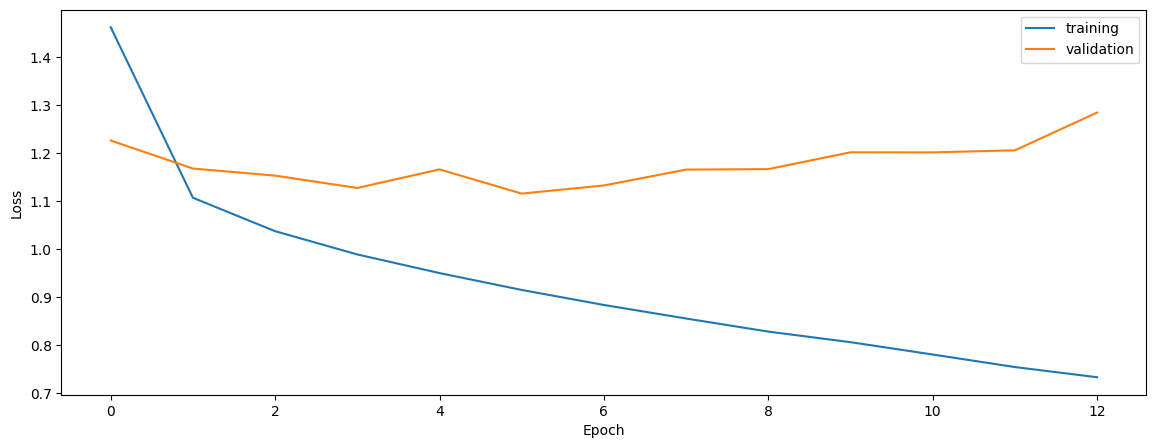

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6586698171869171
0.5831904163553624
0.530771088300862


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5861990662524752
0.5660609037328095
0.5443115207774945


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.573047891387794
0.5490502793296089
0.5299292407726143


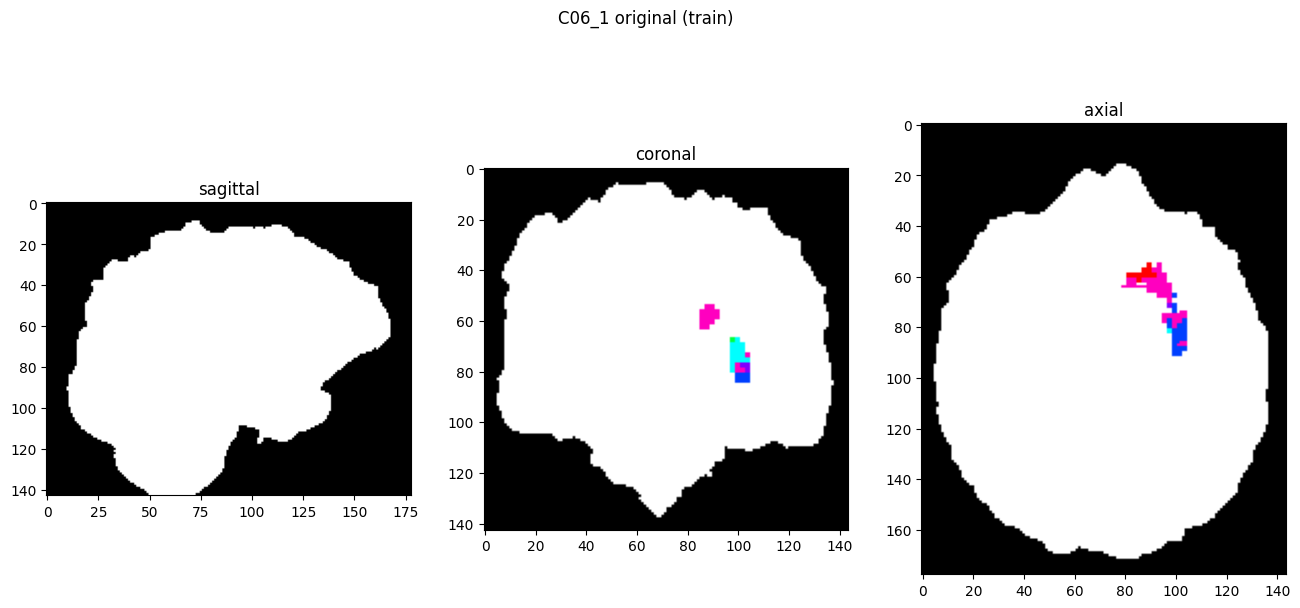

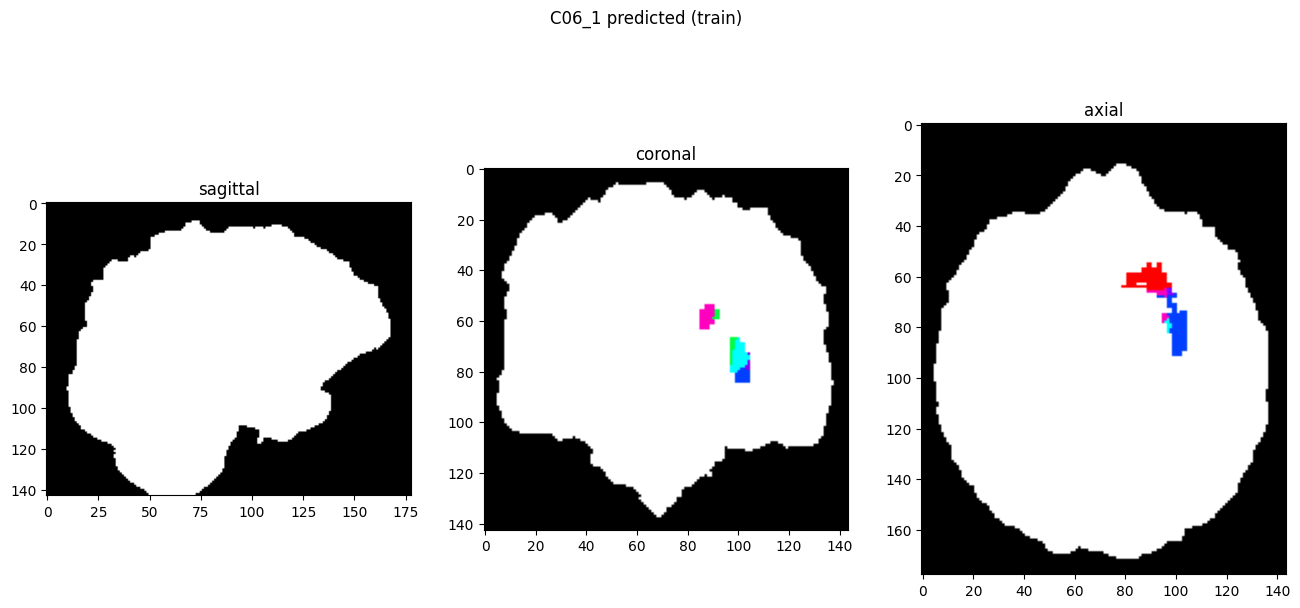

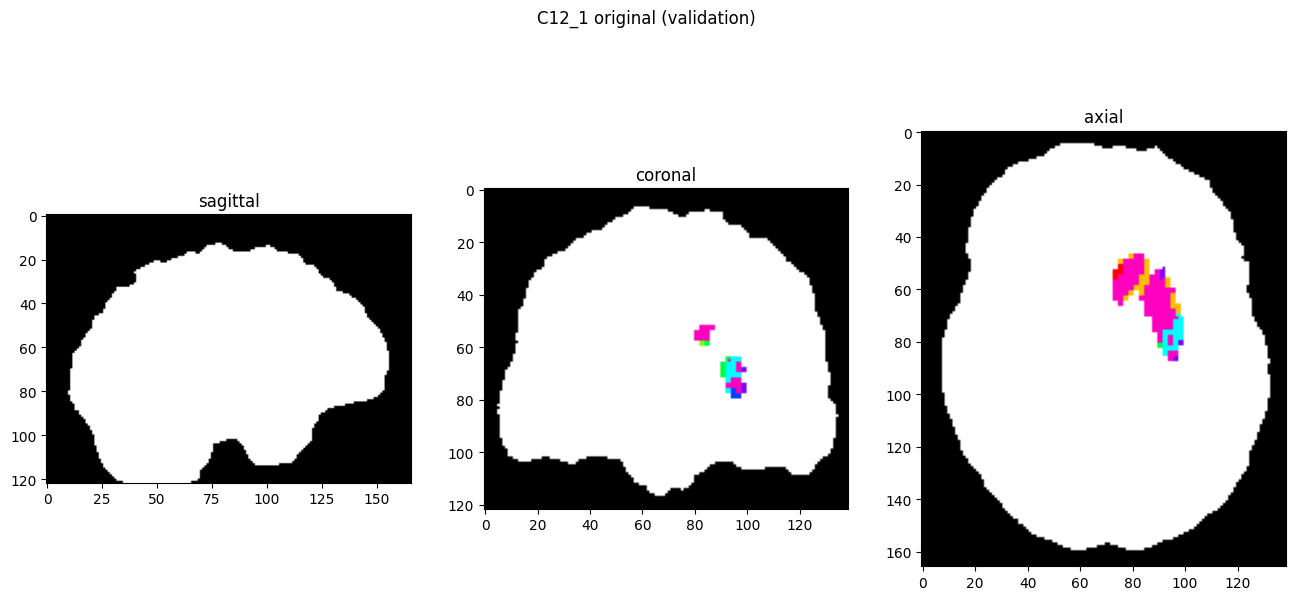

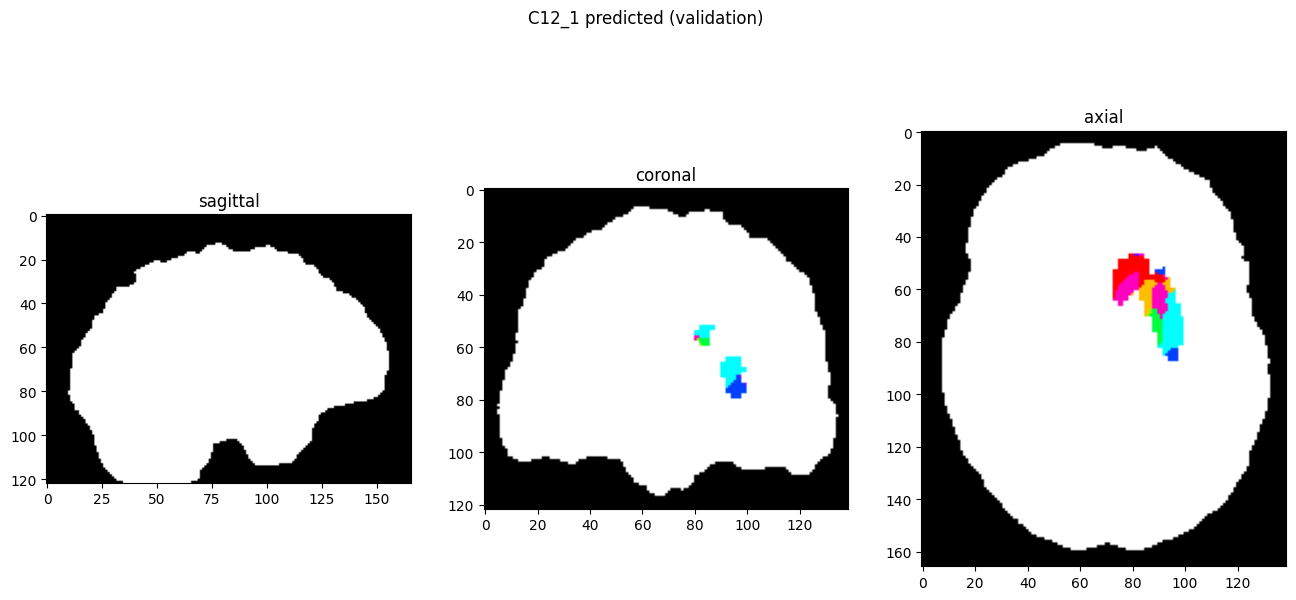

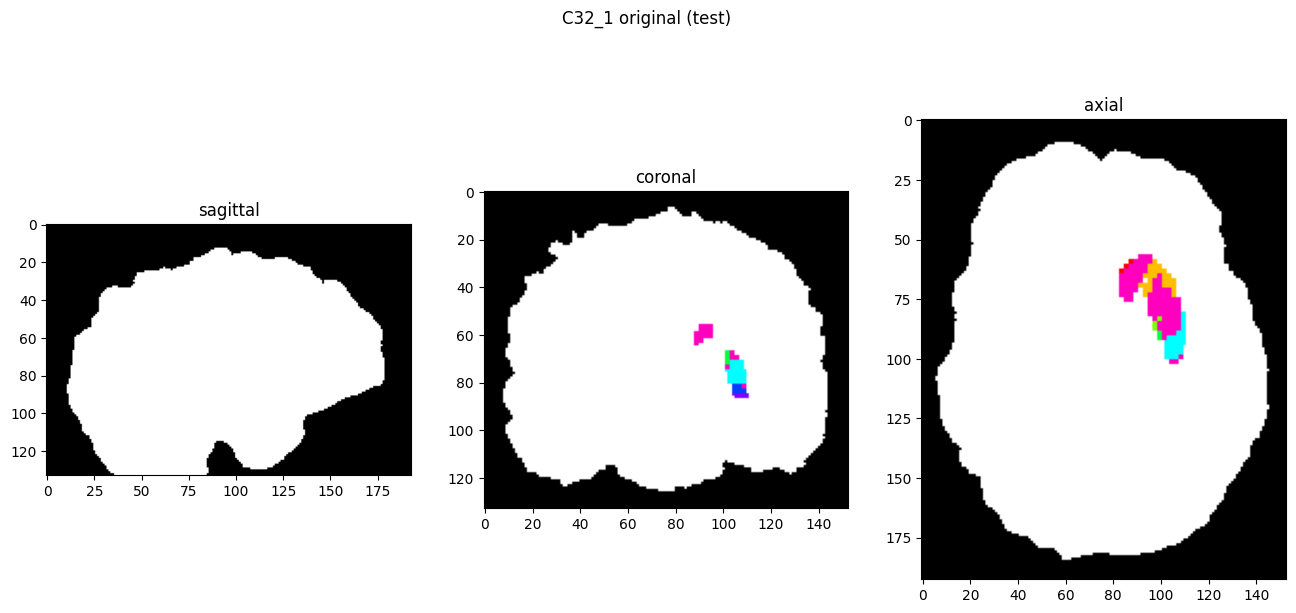

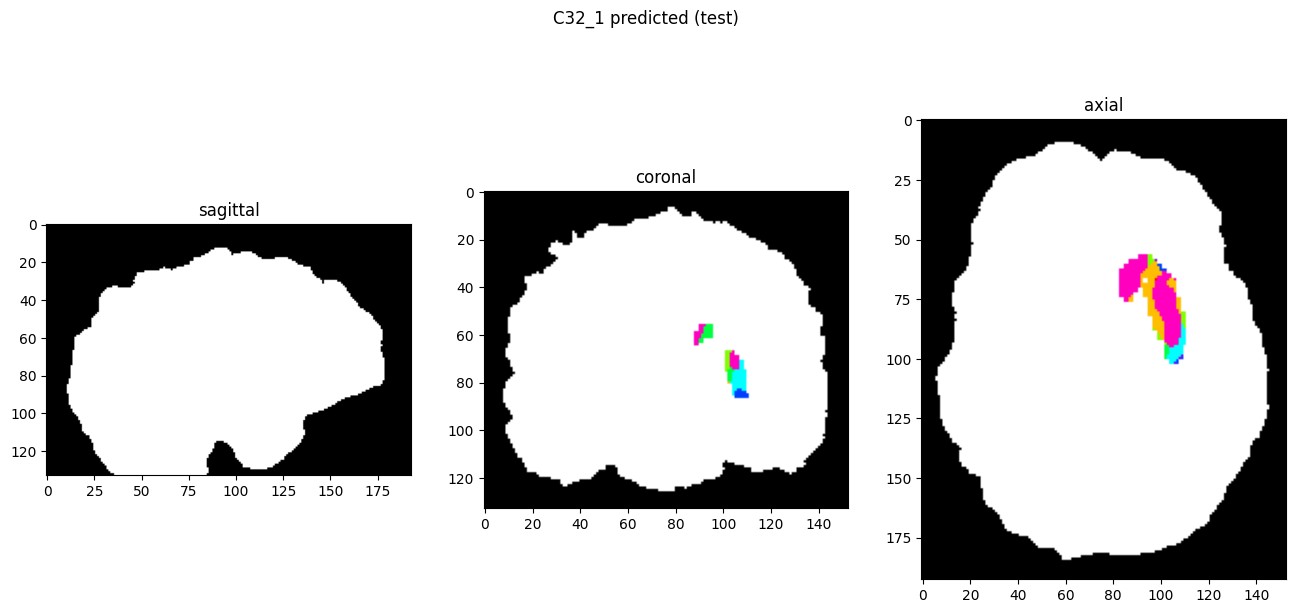

In [10]:
showResults(model, gen, threshold=0)